# Identifying MCXC entries that are blends of multiple clusters

The LoVoCCS sample was originally selected from the MCXC catalog, which was largely created using ROSAT All-Sky Survey (RASS) data - this data has significantly lower spatial resolution than is available to modern pointed observations, and as such extended sources that are near to one another can become blended. Considering the LoVoCCS sample was selected to be above a certain luminosity (and thus mass) limit, we are wish to assess whether any entries have had their luminosity artificially boosted through the combination of multiple sources. 

We have already inspected the modern X-ray data available for the sample, and identified those systems which appear to have multiple components due to ongoing mergers, or other nearby sources. This notebook will create visualisations from RASS images, centered on each selected cluster in LoVoCCS, with the positions of all other MCXC clusters that are nearby overlaid - this will help us to assess which originally selected clusters are likely to be less luminuous than we expected from MCXC.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
import json
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import xga
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.products import Image, ExpMap, RateMap
from xga.imagetools.misc import pix_deg_scale, physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Setting up necessary directories

Here we ensure that the directories we need to store the visualisations in have been created:

In [2]:
stor_dir = "../../outputs/cluster_visualisations/rass_blending_check/"
if not os.path.exists(stor_dir):
    os.makedirs(stor_dir)

## Defining useful functions

We write the function that generates the visualisations here - this isn't just in a cell because we wish to run it twice, once for clusters we have manually split into multiple components, and one for all the other clusters. This isn't an elegant function, in fact it is poorly commented and inefficient, but nevermind:

In [3]:
def visualise_rass(split_clusters: bool = True, label_on_top=None):
    if label_on_top is None:
        label_on_top = []
    
    cut_idents = samp['LoVoCCSID'].apply(lambda x: x if x[-1].isdigit() else x[:-1])
    only_lov_id = list(set(cut_idents.values))

    for lov_id in only_lov_id:
        cur_name = 'LoVoCCS-' + lov_id
        cur_obs_ids = obs_for_clusters[cur_name]

        # Re-find all the LoVoCCS clusters that we have decided to split into multiple components
        all_rel_mask = cut_idents == lov_id
        if all_rel_mask.sum() != 1 and split_clusters:
            rel_row = samp[samp['LoVoCCSID'] == lov_id+'A'].iloc[0]
            oth_rows = samp[all_rel_mask]
            oth_rows = oth_rows[~oth_rows['LoVoCCSID'].str.contains('A')]
        elif all_rel_mask.sum() != 1 and not split_clusters:
            continue
        elif all_rel_mask.sum() == 1 and not split_clusters:
            rel_row = samp[samp['LoVoCCSID'] == lov_id].iloc[0]
            oth_rows = None
        else:
            continue
        
        print(cur_name)
        
        if np.isnan(rel_row['manual_xray_ra']):
            ra = rel_row['MCXC_RA']
            dec = rel_row['MCXC_DEC']
        else:
            ra = rel_row['manual_xray_ra']
            dec = rel_row['manual_xray_dec']

        for oi in cur_obs_ids:
            try:
                cur_im_pth = rass_im_path.format(oi=oi, l_oi=oi.lower())
                cur_ex_pth = rass_ex_path.format(oi=oi, l_oi=oi.lower())

                cur_im = Image(cur_im_pth, oi, 'PSPC', '', '', '', Quantity(0.4, 'keV'), Quantity(2.4, 'keV'))
                cur_ex = ExpMap(cur_ex_pth, oi, 'PSPC', '', '', '', Quantity(0.4, 'keV'), Quantity(2.4, 'keV'))
                cur_rt = RateMap(cur_im, cur_ex)
                cur_rt.src_name = cur_name

                zoom_mask = np.zeros(cur_rt.shape)
                zoom_cen = cur_rt.coord_conv(Quantity([ra, dec], 'deg'), 'pix').value
                pds = pix_deg_scale(Quantity([ra, dec], 'deg'), cur_rt.radec_wcs)

                ang_half_len = rad_to_ang(Quantity(2000, 'kpc'), rel_row['MCXC_Redshift'])
                zoom_half_len = ((ang_half_len / pds).to('pix')).astype(int).value
                
                y_lims = [zoom_cen[1]-zoom_half_len, zoom_cen[1]+zoom_half_len]
                x_lims = [zoom_cen[0]-zoom_half_len, zoom_cen[0]+zoom_half_len]
                zoom_mask[y_lims[0]:y_lims[1], 
                          x_lims[0]:x_lims[1]] = 1
                
                if (cur_rt.data.copy()*zoom_mask).sum() == 0:
                    continue
                    
                fig = plt.figure(figsize=(8, 8))
                ax = plt.gca()
                ax.set_facecolor("black")
                
                cur_rt.get_view(ax, mask=zoom_mask, zoom_in=True, manual_zoom_xlims=x_lims, 
                                manual_zoom_ylims=y_lims)
                
                plt.plot(zoom_cen[0], zoom_cen[1], 'D', markersize=20, color='tab:blue', 
                             markerfacecolor='none', mew=3)
                ax.annotate("LoVoCCS-" + rel_row['LoVoCCSID'], (zoom_cen[0], zoom_cen[1]), fontsize=13, 
                            xycoords='data', color='white', weight='bold',
                            textcoords='offset points', xytext=(30, 30),
                            bbox=dict(facecolor='black', alpha=0.85, edgecolor='black'), zorder=10,
                            arrowprops=dict(facecolor='lightsteelblue', edgecolor='lightsteelblue', 
                                            shrink=0.05, width=2))
                
                if oth_rows is not None:
                    oth_deg_pos = Quantity(oth_rows[['manual_xray_ra', 'manual_xray_dec']].values, 'deg')
                    oth_pix_pos = cur_rt.coord_conv(oth_deg_pos, 'pix').value
                    
                    if oth_pix_pos.ndim == 1:
                        x_pix = oth_pix_pos[0]
                        y_pix = oth_pix_pos[1]
                        
                        ax.annotate("LoVoCCS-" + oth_rows.iloc[0]['LoVoCCSID'], (x_pix, y_pix), fontsize=13, 
                                    xycoords='data', color='white', weight='bold', 
                                    textcoords='offset points', xytext=(-70, -40),
                                    bbox=dict(facecolor='black', alpha=0.85, edgecolor='black'), zorder=10,
                                    arrowprops=dict(facecolor='lightsteelblue', edgecolor='lightsteelblue', 
                                                    shrink=0.05, width=2))

                    else:
                        x_pix = oth_pix_pos[:, 0]
                        y_pix = oth_pix_pos[:, 1]
                        for pix_ind, cur_x_pix in enumerate(x_pix):                            
                            ax.annotate("LoVoCCS-" + oth_rows['LoVoCCSID'].values[pix_ind], 
                                        (x_pix[pix_ind], y_pix[pix_ind]), fontsize=13, 
                                        xycoords='data', color='white', weight='bold', 
                                        textcoords='offset points', xytext=(-70, -40),
                                        bbox=dict(facecolor='black', alpha=0.85, edgecolor='black'), zorder=10,
                                        arrowprops=dict(facecolor='lightsteelblue', edgecolor='lightsteelblue', 
                                                        shrink=0.05, width=2))

                    plt.plot(x_pix, y_pix, 'D', markersize=15, color='white', markerfacecolor='white', mew=2.5)
                
                # This is awful
                for mcxc_row_ind, mcxc_row in mcxc.iterrows():
                    try:
                        mcxc_deg_pos = Quantity(mcxc_row[['RA', 'DEC']].values, 'deg')
                        pix_pos = cur_rt.coord_conv(mcxc_deg_pos, 'pix').value
                    except ValueError as err:
                        pass
                    else:
                        pix_r500 = physical_rad_to_pix(cur_rt, Quantity(mcxc_row['RADIUS_500'], 'Mpc'), 
                                                       mcxc_deg_pos, mcxc_row['REDSHIFT'], 
                                                       xga.DEFAULT_COSMO).value
                        
                        mcxc_artist = Circle(pix_pos, pix_r500, fill=False, ec='white', linewidth=1.6,
                                        linestyle='dashed')
                        if mcxc_row['NAME'] in label_on_top:
                            y_off = pix_r500
                        else:
                            y_off = -pix_r500
                        ax.annotate(mcxc_row['NAME'], (pix_pos[0], pix_pos[1]+y_off), fontsize=13, 
                                        xycoords='data', color='white', weight='bold', 
                                        textcoords='offset points', xytext=(-70, -0),
                                        bbox=dict(facecolor='black', alpha=0.85, edgecolor='black'), zorder=10)
                        ax.add_artist(mcxc_artist)
                
                for oth_lov_id in only_lov_id:
                    if oth_lov_id == lov_id:
                        continue
                        
                    all_oth_rel_mask = cut_idents == oth_lov_id
                    if all_oth_rel_mask.sum() != 1:
                        oth_lov_rel_row = samp[samp['LoVoCCSID'] == oth_lov_id+'A'].iloc[0]
                    elif all_oth_rel_mask.sum() == 1:
                        oth_lov_rel_row = samp[samp['LoVoCCSID'] == oth_lov_id].iloc[0]

                    if np.isnan(oth_lov_rel_row['manual_xray_ra']):
                        oth_lov_ra = oth_lov_rel_row['MCXC_RA']
                        oth_lov_dec = oth_lov_rel_row['MCXC_DEC']
                    else:
                        oth_lov_ra = oth_lov_rel_row['manual_xray_ra']
                        oth_lov_dec = oth_lov_rel_row['manual_xray_dec']

                    try:
                        oth_lov_deg_pos = Quantity([oth_lov_ra, oth_lov_dec], 'deg')
                        oth_lov_pix_pos = cur_rt.coord_conv(oth_lov_deg_pos, 'pix').value
                    except ValueError as err:
                        pass
                    else:
                        plt.plot(oth_lov_pix_pos[0], oth_lov_pix_pos[1], 'D', markersize=20, color='tab:blue', 
                                 markerfacecolor='none', mew=3)
                        ax.annotate("LoVoCCS-" + oth_lov_id, 
                                    (oth_lov_pix_pos[0], oth_lov_pix_pos[1]), 
                                    fontsize=13, 
                                    xycoords='data', color='white', weight='bold',
                                    textcoords='offset points', xytext=(30, 30),
                                    bbox=dict(facecolor='black', alpha=0.85, edgecolor='black'), zorder=10,
                                    arrowprops=dict(facecolor='lightsteelblue', edgecolor='lightsteelblue', 
                                                    shrink=0.05, width=2))
                
                plt.tight_layout()
                file_name = "{n}_{oi}.pdf".format(n=cur_name, oi=oi)
                plt.savefig("../../outputs/cluster_visualisations/rass_blending_check/"+file_name)
                plt.show()
                plt.close('all')
            except ValueError:
                pass

## Loading the sample

We load the LoVoCCS sample relevant to this work, which already contains information on instances where we have identified that the target cluster has multiple components (which generally means they are undergoing a merger). We'll use this information to fetch the appropriate RASS images:

In [4]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp

,LoVoCCSID,Name,MCXC_RA,MCXC_DEC,MCXC_Redshift,manual_xray_ra,manual_xray_dec
0,1,A2029,227.73000,5.720000,0.0766,227.734300,5.745471
1,2,A401,44.74000,13.580000,0.0739,NaN,NaN
2,4,A85,10.45875,-9.301944,0.0555,NaN,NaN
3,5,A3667,303.13000,-56.830000,0.0556,303.157313,-56.845978
4,7,A3827,330.48000,-59.950000,0.0980,NaN,NaN
...,...,...,...,...,...,...,...
61,121,A3128,52.50000,-52.600000,0.0624,52.466189,-52.580728
62,122,A1023,157.00000,-6.800000,0.1176,NaN,NaN
63,123,A3528,193.67000,-29.220000,0.0544,NaN,NaN
64,131,A761,137.65125,-10.581111,0.0916,NaN,NaN


We also want the whole MCXC catalog, as the point of this notebook is identifying whether the other components of galaxy clusters that we have identified as merging are also present individually in the catalogue. We assume here that the LoVoCCS-Sample repository has been cloned into the same directory as this X-LoVoCCS-Analyses repository):

In [5]:
mcxc = pd.read_csv("../../../LoVoCCS-Sample/mcxc_selection/full_mcxc.csv")
mcxc

,NAME,ALT_NAME,OTHER_NAMES,RA,DEC,LII,BII,REDSHIFT,CATALOG_NAME,SUB_CATALOG_NAME,LINEAR_SCALE_FACTOR,LX_500,MASS_500,RADIUS_500,NOTES,OVERLAP_CAT_1,OVERLAP_CAT_2,OVERLAP_CAT_3,OVERLAP_CAT_4,LX_RATIO_CAT_1,LX_RATIO_CAT_2,LX_RATIO_CAT_3,LX_RATIO_CAT_4
0,MCXC J2340.1-8510,RXC J2340.1-8510,A4023 ...,355.0429,-85.1783,304.6643,-31.7080,0.1934,NORAS/REFLEX,REFLEX,3.214,2.901909e+44,3.414300e+14,0.9969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MCXC J1539.5-8335,RXC J1539.5-8335,NaN,234.8913,-83.5922,307.5642,-22.2939,0.0728,NORAS/REFLEX,REFLEX,1.386,2.235082e+44,3.177000e+14,1.0138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MCXC J0948.6-8327,RXC J0948.6-8327,NaN,147.1642,-83.4656,297.8757,-22.4749,0.1982,NORAS/REFLEX,REFLEX,3.276,2.944476e+44,3.432300e+14,0.9970,"D,two maxima/E-W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MCXC J2104.9-8243,RXC J2104.9-8243,A3728 ...,316.2446,-82.7228,310.0164,-30.9537,0.0969,NORAS/REFLEX,REFLEX,1.793,7.085100e+43,1.550600e+14,0.7920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MCXC J0351.1-8212,RXC J0351.1-8212,S0405 ...,57.7871,-82.2167,296.4215,-32.4876,0.0613,NORAS/REFLEX,REFLEX,1.183,1.200899e+44,2.192400e+14,0.8992,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,MCXC J1231.3+8225,RXC J1231.3+8225,NaN,187.8496,82.4281,123.7336,34.6690,0.2053,NORAS/REFLEX,NORAS,3.368,2.099382e+44,2.777600e+14,0.9267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1739,MCXC J1641.1+8232,BVH2007 207,VMF98 183 ...,250.2958,82.5406,115.6020,30.9516,0.2060,400SD,400SD_SER,3.377,1.332633e+44,2.104200e+14,0.8446,NaN,SHARC_BRIGHT,160SD,NaN,NaN,0.907,1.019,NaN,NaN
1740,MCXC J0035.9+8513,WARP J0035.9+8513,NaN,8.9971,85.2214,122.5843,22.3601,0.8317,WARPS,WARPSII,7.606,3.208750e+44,2.139700e+14,0.6659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1741,MCXC J0046.3+8530,WARP J0046.3+8530,NaN,11.5808,85.5158,122.8236,22.6452,0.6241,WARPS,WARPSII,6.807,3.352002e+44,2.621200e+14,0.7739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Identifying the relevant RASS ObsIDs

The RASS data have already been acquired by the notebooks in the X-LoVoCCS-Data repository (which we assume is cloned into the same directory as this X-LoVoCCS-Analyses repository), and the particular ObsIDs associated with each source have also been stored - we load this file in as a dictionary, where top level keys are LoVoCCS cluster names, lower level keys are mission names, and values are lists of ObsIDs:

In [6]:
with open("../../../X-LoVoCCS-Data/data_notes/rel_obs_for_clusters.json", 'r') as reado:   
    obs_for_clusters = json.load(reado)
# Showing one example of the entries in this dictionary
obs_for_clusters['LoVoCCS-5']

{'xmm_pointed': ['0653050201',
  '0653050801',
  '0206850101',
  '0653050601',
  '0653050301',
  '0761210101',
  '0205330401',
  '0042341101',
  '0653050401',
  '0105260101',
  '0553180101',
  '0653050501',
  '0744390401',
  '0105260401',
  '0105260501',
  '0105260201',
  '0105260601',
  '0105260301'],
 'chandra': ['5753',
  '17203',
  '4995',
  '17202',
  '5751',
  '5752',
  '513',
  '6295',
  '6296',
  '7686',
  '17698',
  '889',
  '6292'],
 'rosat_pointed_pspc': ['RP200580N00', 'RP800234N00'],
 'rosat_pointed_hri': ['RH800822N00'],
 'rosat_all_sky': ['RS932733N00', 'RS932734N00'],
 'swift_xrt': ['07021858001',
  '00093360006',
  '00093360008',
  '00093360005',
  '00093360002',
  '00093360004'],
 'asca': ['83054000', '87003000', '87004000']}

We only care about the all-sky data here, so we cut the dictionary down:

In [7]:
obs_for_clusters = {n: m['rosat_all_sky'] for n, m in obs_for_clusters.items()}
obs_for_clusters

{'LoVoCCS-0': ['RS931239N00'],
 'LoVoCCS-1': ['RS931641N00'],
 'LoVoCCS-2': ['RS931508N00'],
 'LoVoCCS-3': ['RS931234N00'],
 'LoVoCCS-4': ['RS931802N00', 'RS931902N00'],
 'LoVoCCS-5': ['RS932733N00', 'RS932734N00'],
 'LoVoCCS-6': ['RS931238N00', 'RS931136N00'],
 'LoVoCCS-7': ['RS932831N00', 'RS932736N00'],
 'LoVoCCS-8': ['RS931139N00', 'RS931140N00'],
 'LoVoCCS-9': ['RS932807N00'],
 'LoVoCCS-10': ['RS931735N00', 'RS931835N00'],
 'LoVoCCS-11': ['RS931925N00'],
 'LoVoCCS-12': ['RS932332N00'],
 'LoVoCCS-13': ['RS932507N00'],
 'LoVoCCS-14': ['RS931508N00'],
 'LoVoCCS-15': ['RS931963N00'],
 'LoVoCCS-16': ['RS930312N00'],
 'LoVoCCS-17': ['RS931136N00', 'RS931135N00'],
 'LoVoCCS-18': ['RS931735N00', 'RS931835N00'],
 'LoVoCCS-19': ['RS933101N00'],
 'LoVoCCS-20': ['RS932042N00', 'RS931943N00'],
 'LoVoCCS-21': ['RS932331N00', 'RS932332N00', 'RS932233N00'],
 'LoVoCCS-22': ['RS932445N00', 'RS932348N00'],
 'LoVoCCS-23': ['RS930624N00'],
 'LoVoCCS-24': ['RS932927N00', 'RS932832N00'],
 'LoVoCCS-25': 

## RASS visualisations

Here we make the actual visualisations, using RASS data, to show where our LoVoCCS clusters fall (with a particular interest in those we have manually split into multiple components), as well as where any other MCXC entries in the vicinity fall. 

This involves reading in RASS images and exposure maps (using them to make a ratemap), zooming in on a region with side length 4000 Mpc (centered on the main LoVoCCS component, using our manually corrected coordinates if they are present), and then overlaying information about the locations of other sources.

All of these visualisations are saved to disk, in the outputs/visualisations/rass_blending_check section of this repository.

First off, we define some paths to images and exposure maps (these shouldn't really be here, but the visualisation function is so inelegantly done it hardly seems to matter):

In [8]:
rass_path = "../../../X-LoVoCCS-Data/data/rosat_all_sky_raw/"
rass_im_path = rass_path + "{oi}/{l_oi}_im1.fits"
rass_ex_path = rass_path + "{oi}/{l_oi}_mex.fits"

### Split-up LoVoCCS clusters

This notebook is primarily to check on the clusters we have already flagged as having ICM emission consistent with being interacting clusters, so we start off with those ones. What we have identified as the primary component is identified by a blue diamond, and any other components are highlighted by filled white diamonds (all are labelled). All nearby MCXC entries are shown by white dashed circles indicating the MCXC $R_{500}$, with the name on the bottom or top of the circle. Multiple RASS visualisations may occur when the cluster is near the edge of a RASS tile:

LoVoCCS-41


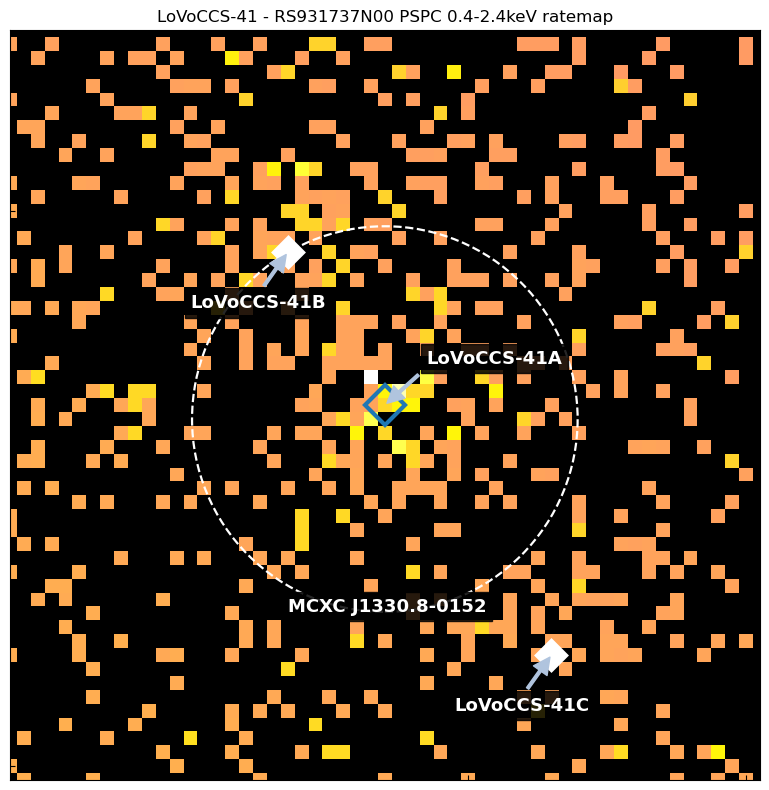

LoVoCCS-66


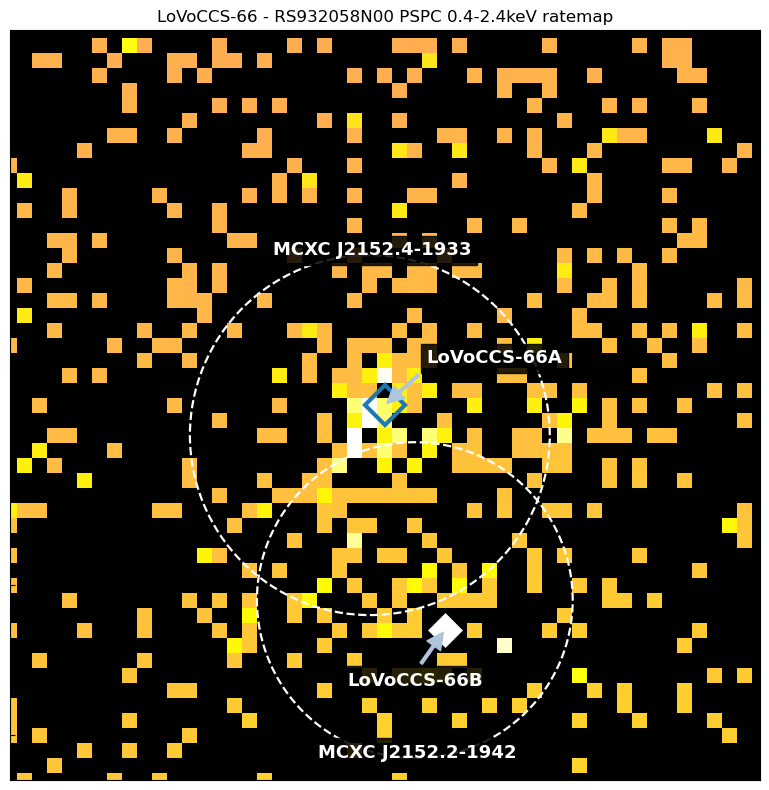

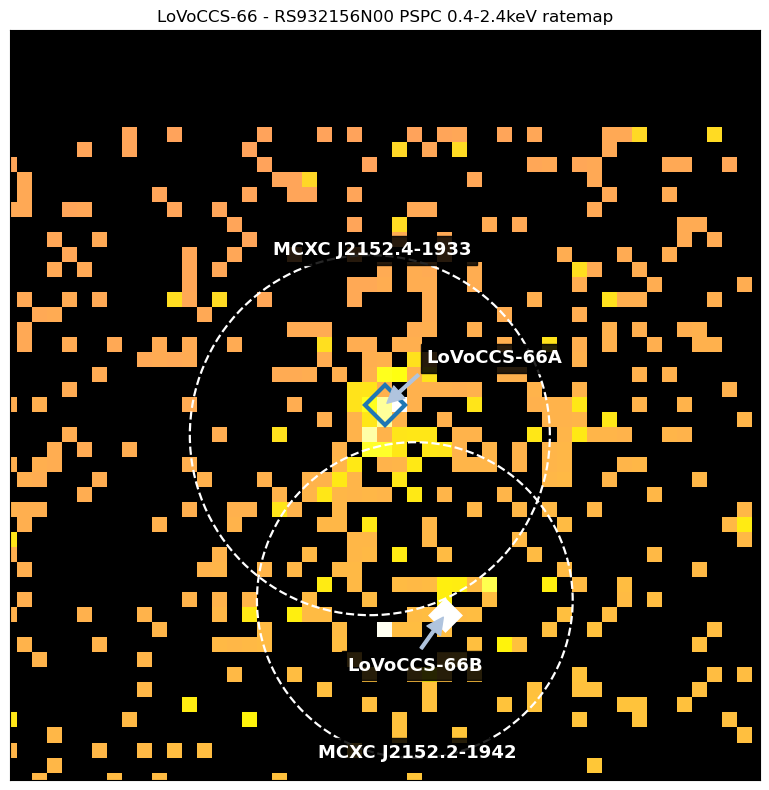

LoVoCCS-46


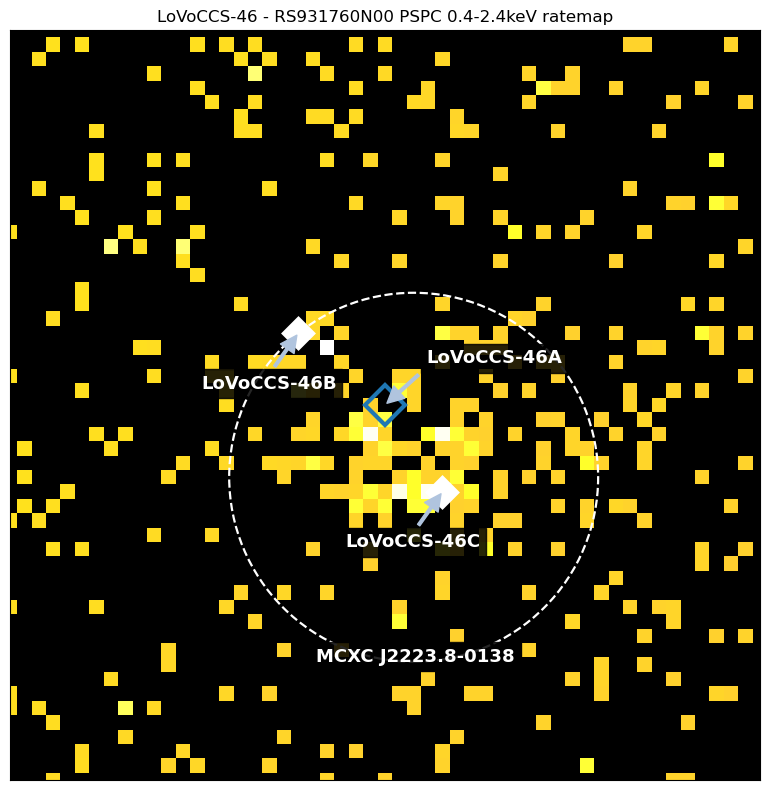

LoVoCCS-60


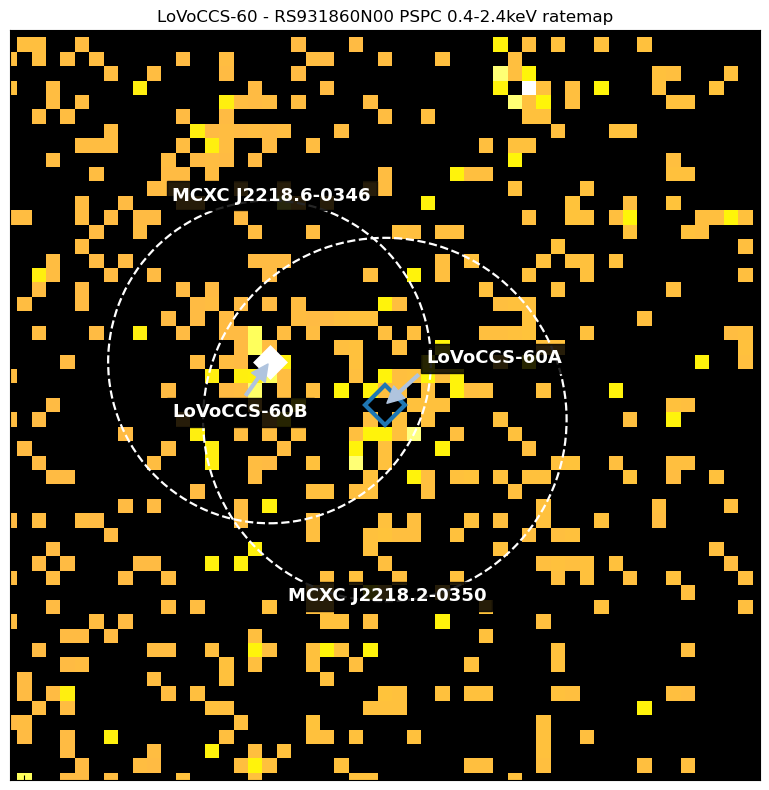

LoVoCCS-93


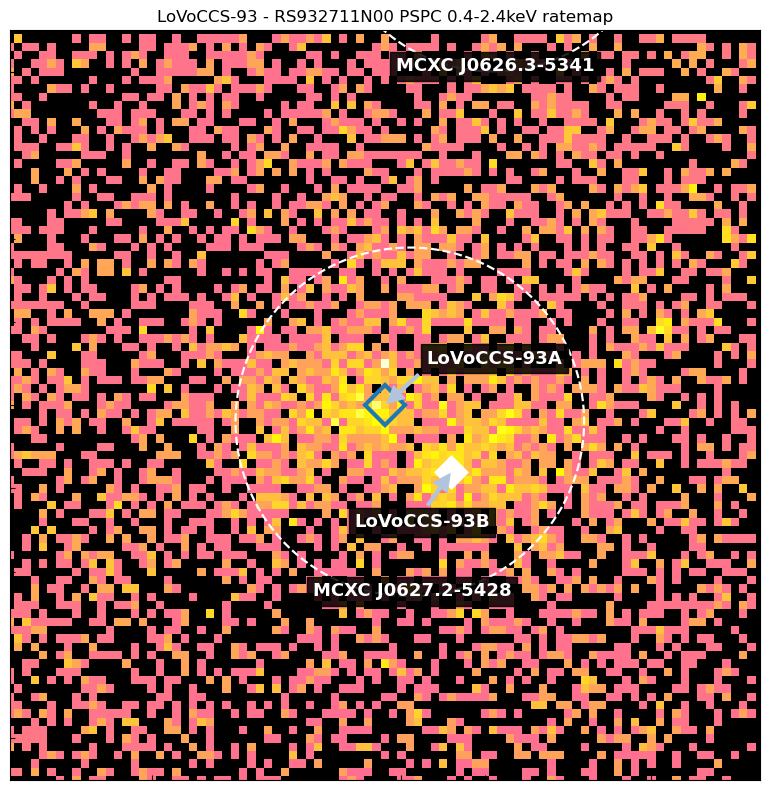

LoVoCCS-48


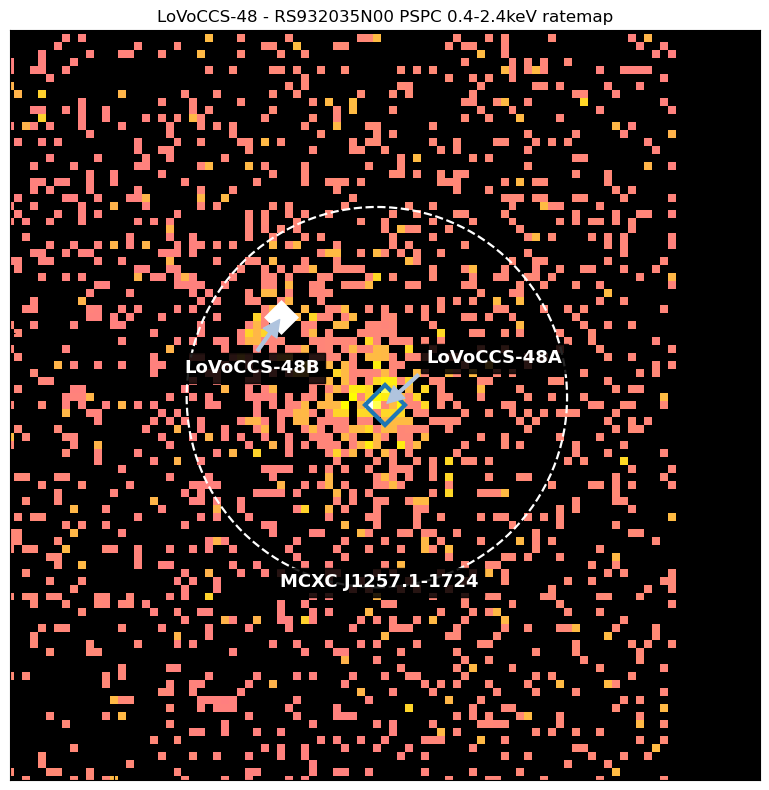

In [9]:
visualise_rass(split_clusters=True, label_on_top=['MCXC J2152.4-1933', 'MCXC J2218.6-0346'])

### Other LoVoCCS clusters

We also make equivalent visualisations of the other clusters in the current LoVoCCS sample:

LoVoCCS-1


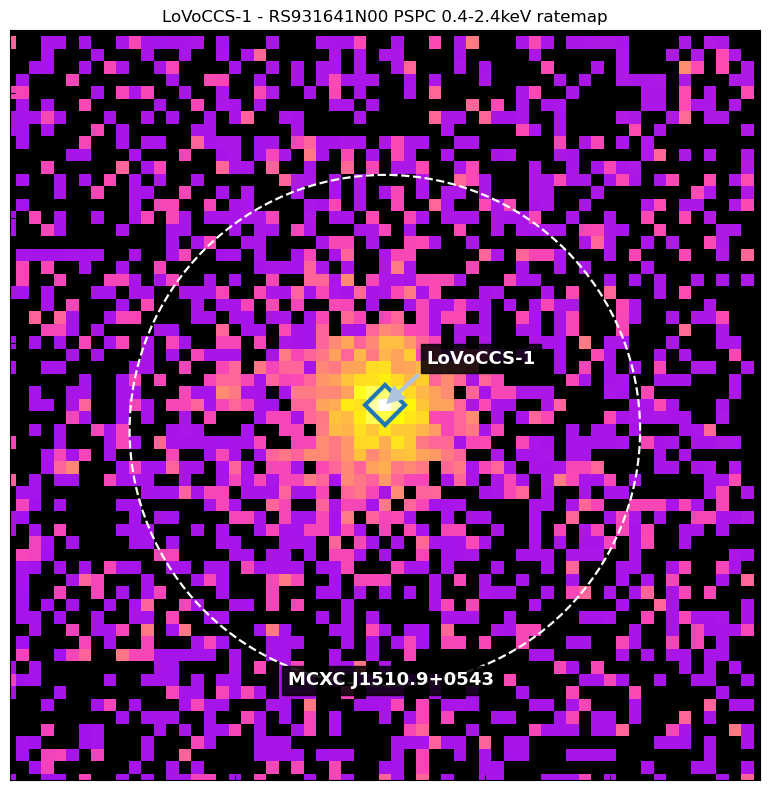

LoVoCCS-28


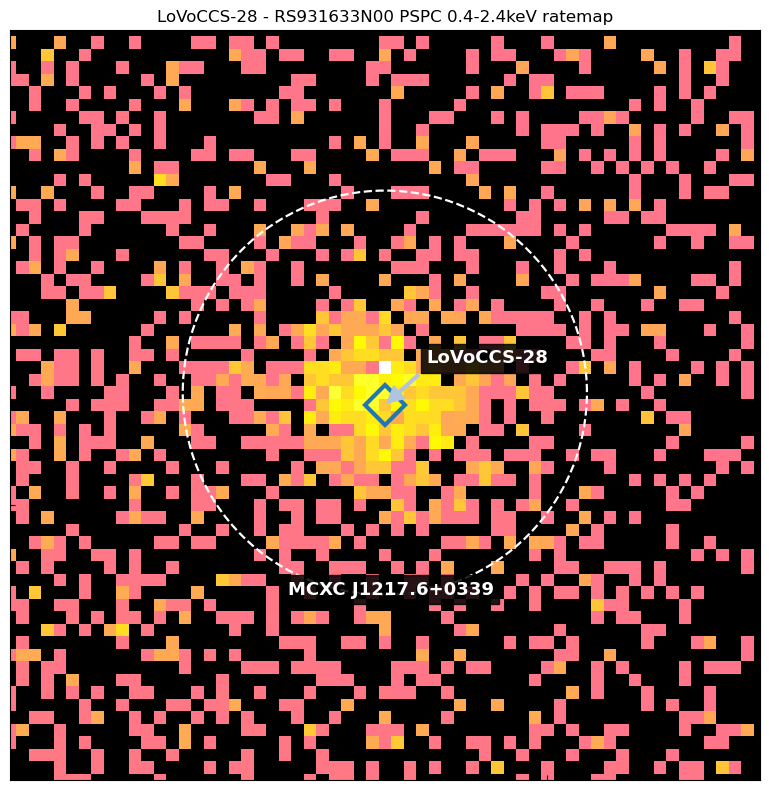

LoVoCCS-122


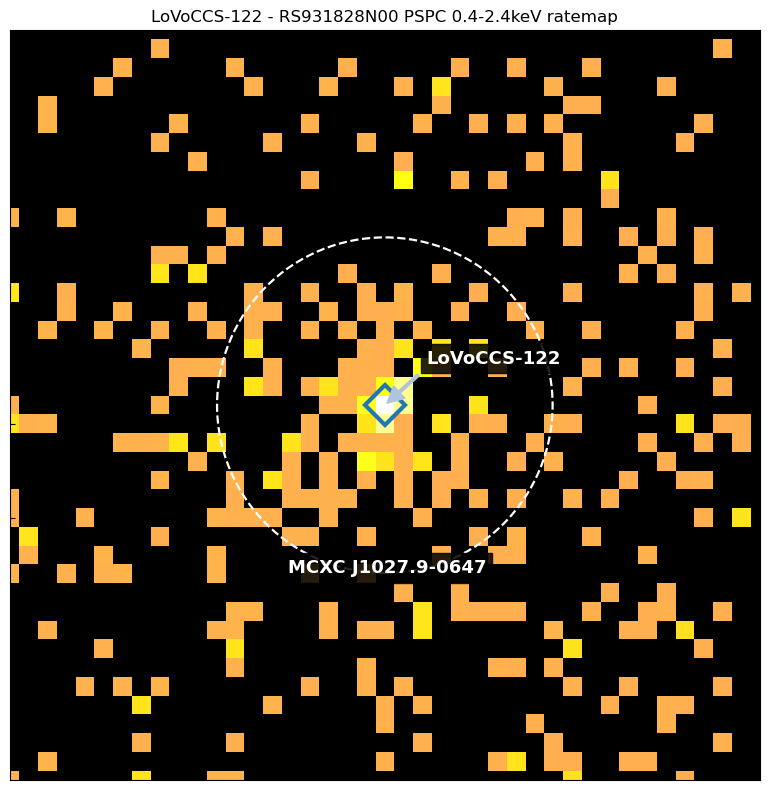

LoVoCCS-4


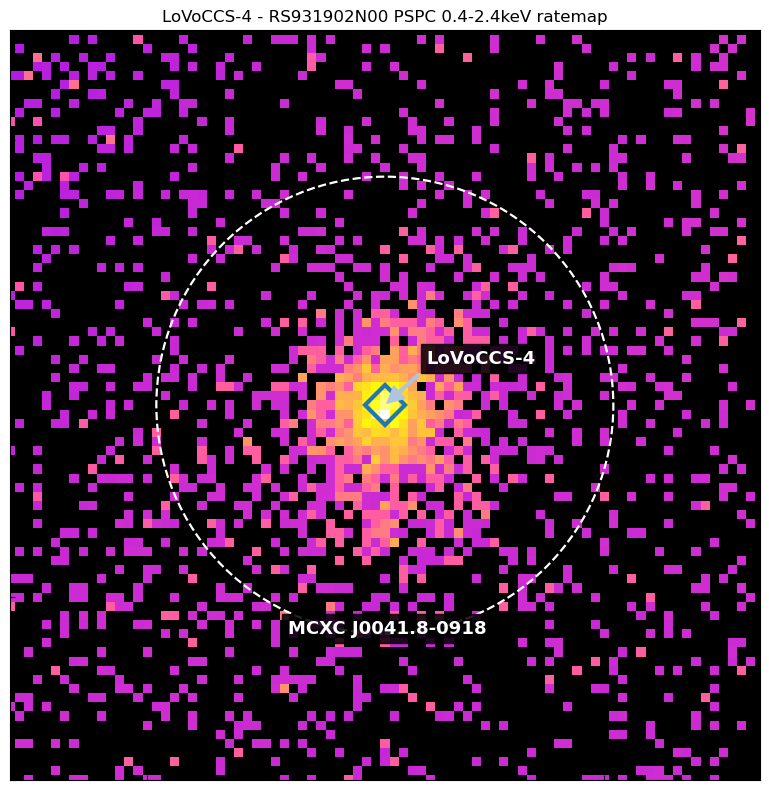

LoVoCCS-14


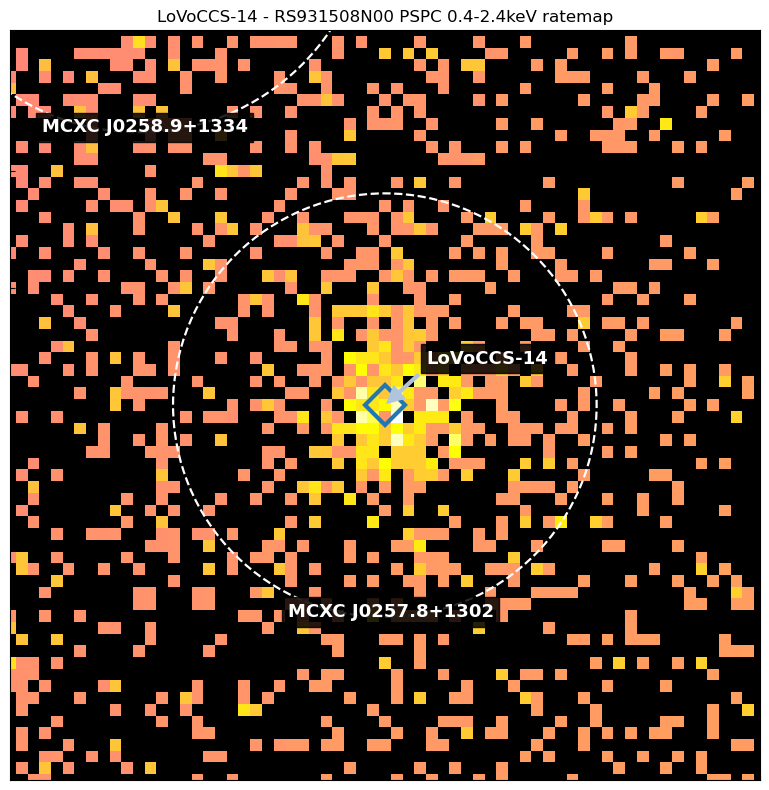

LoVoCCS-24


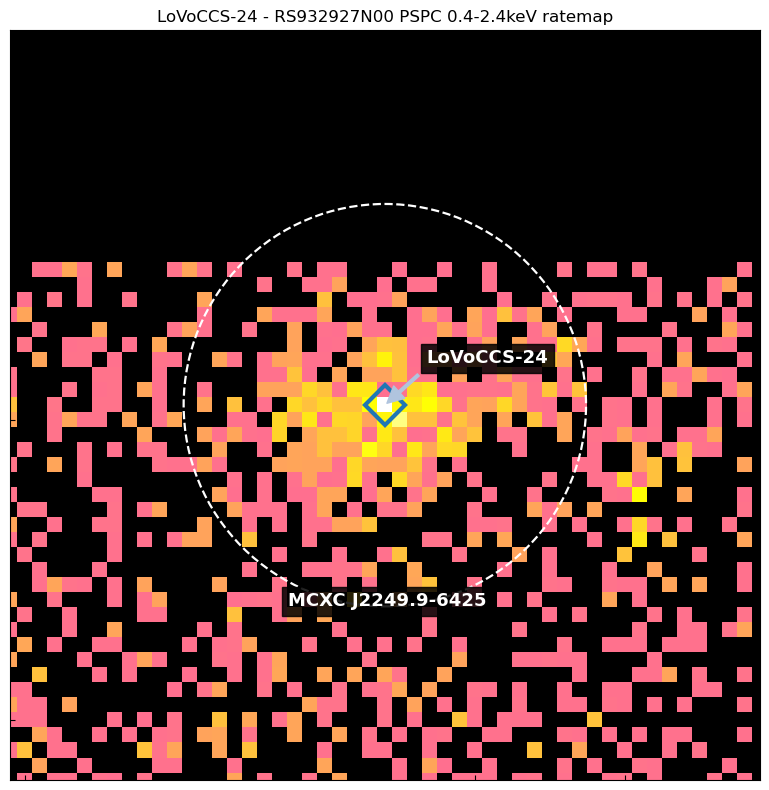

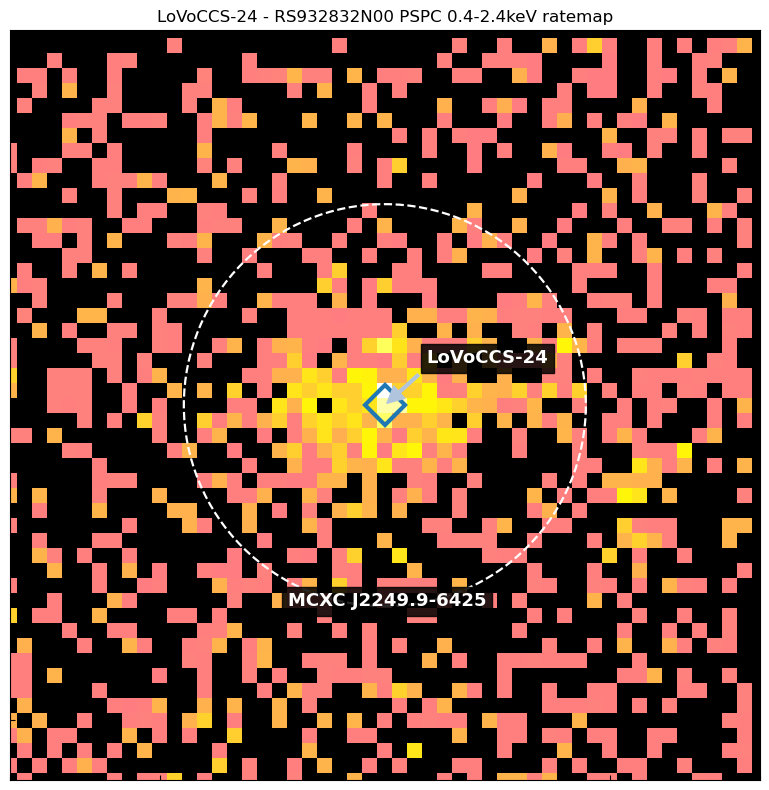

LoVoCCS-35


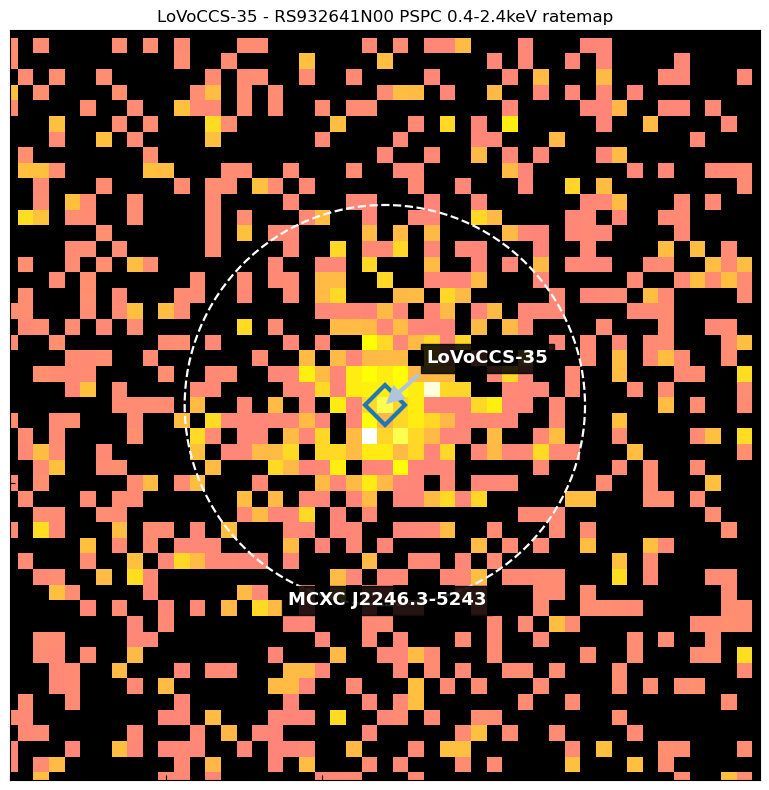

LoVoCCS-123


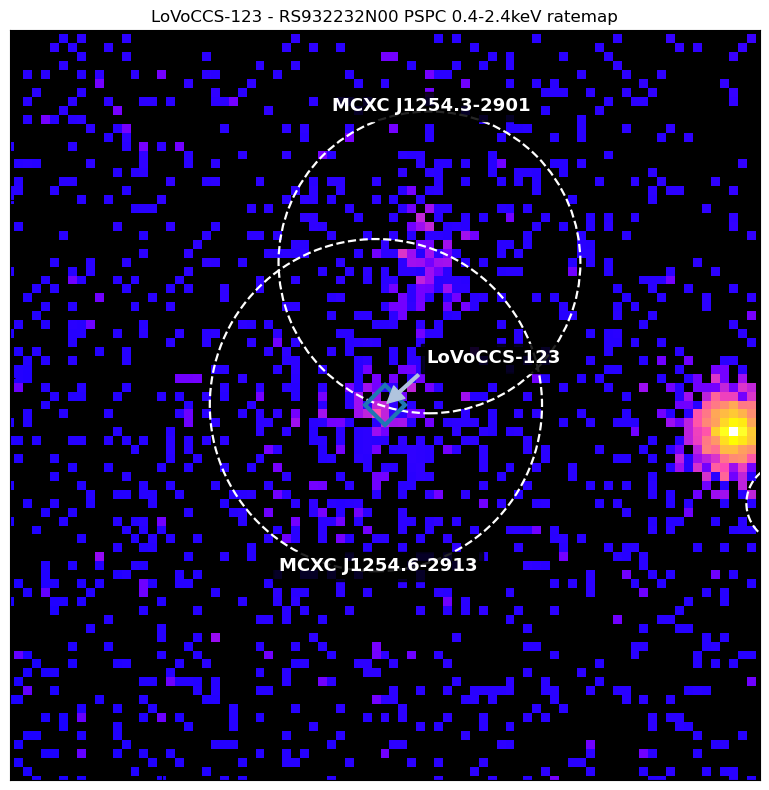

LoVoCCS-13


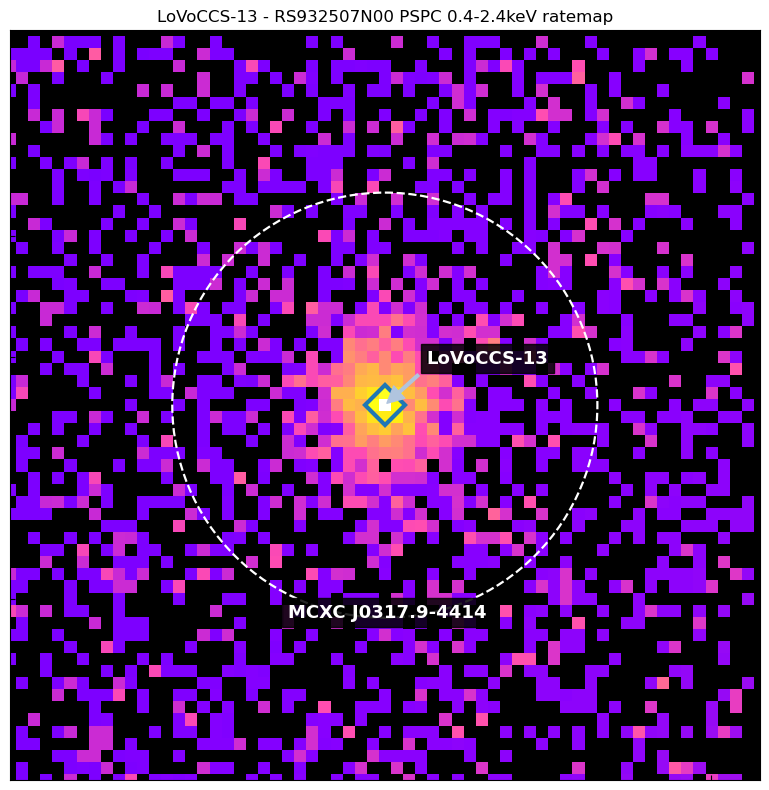

LoVoCCS-51


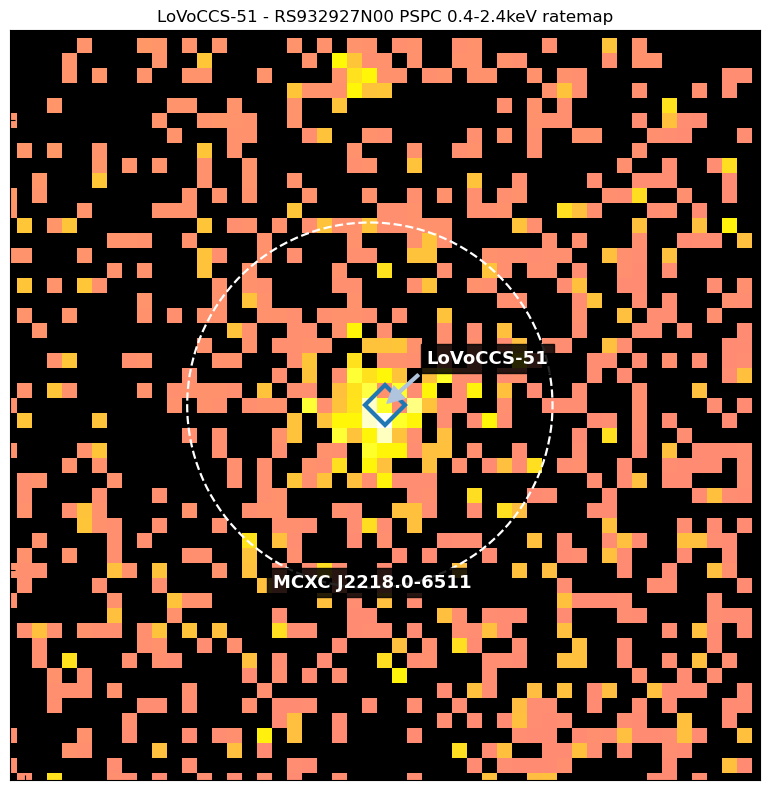

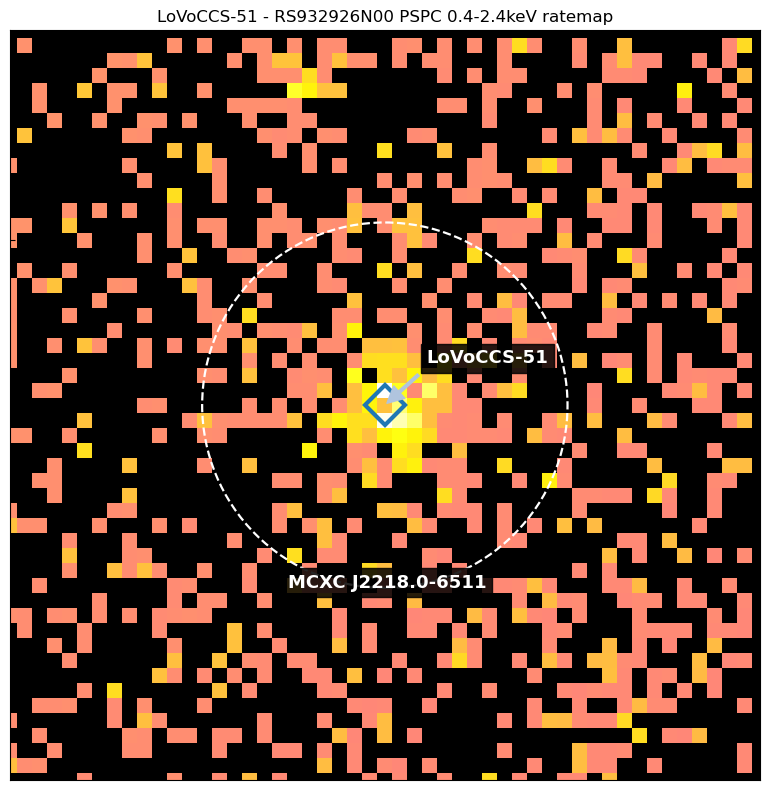

LoVoCCS-67


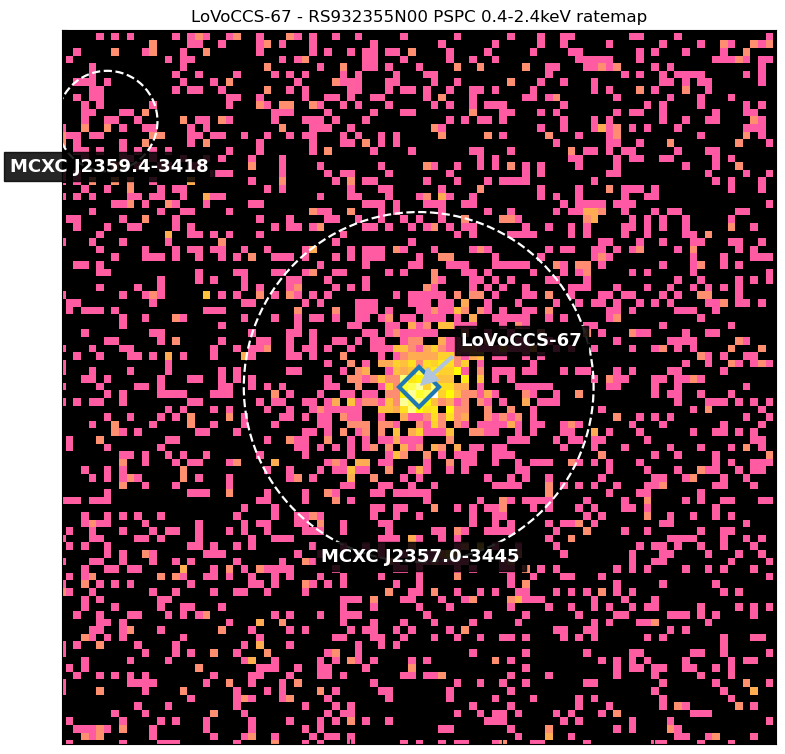

LoVoCCS-58


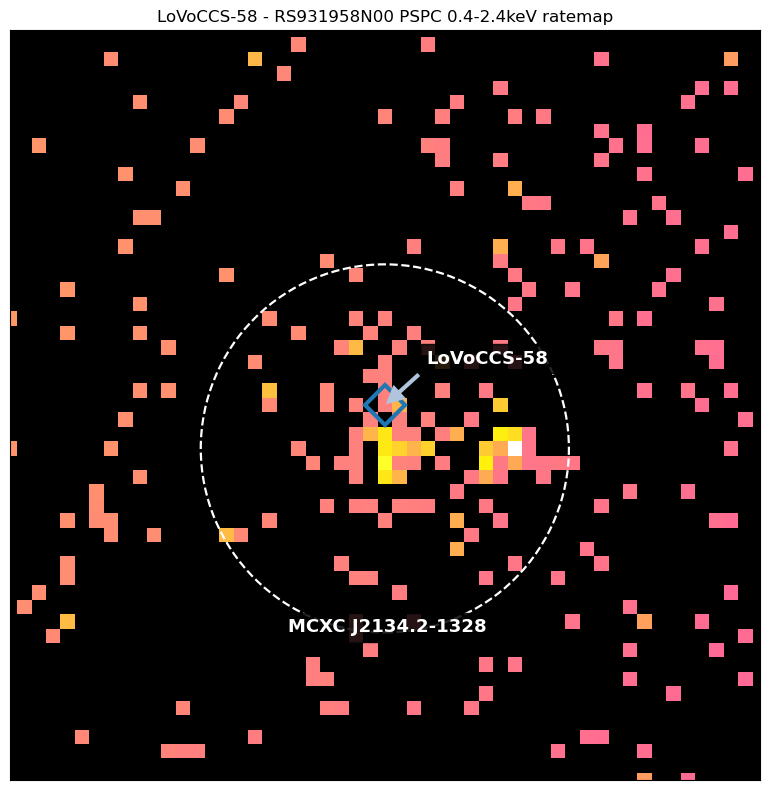

LoVoCCS-21


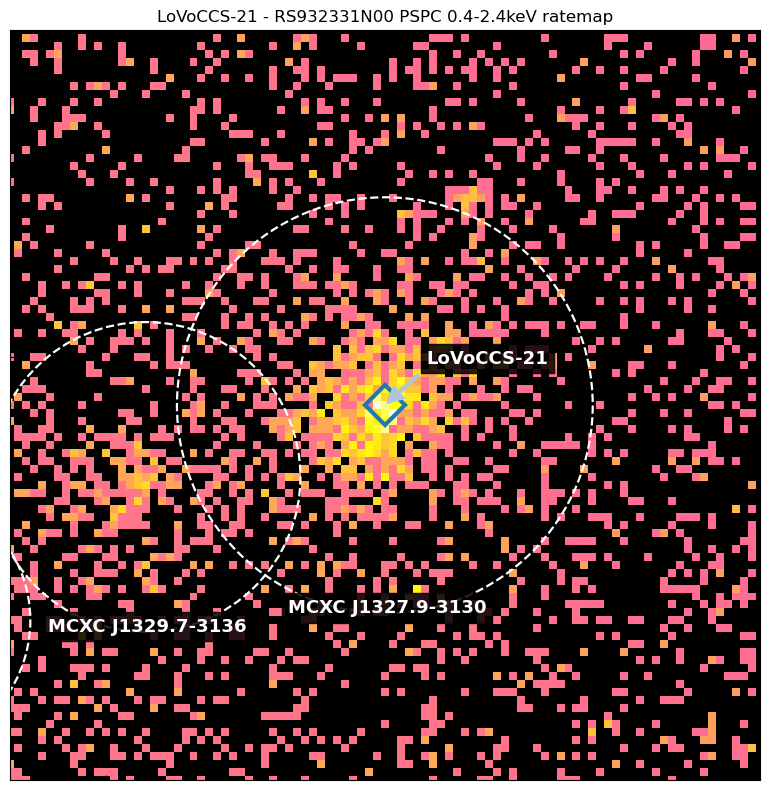

LoVoCCS-15


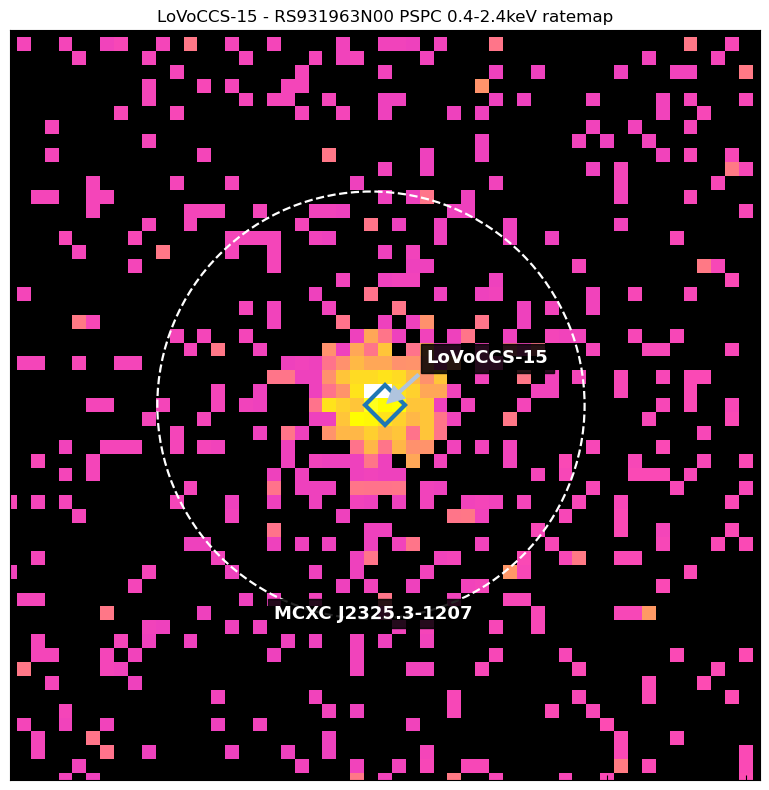

LoVoCCS-55


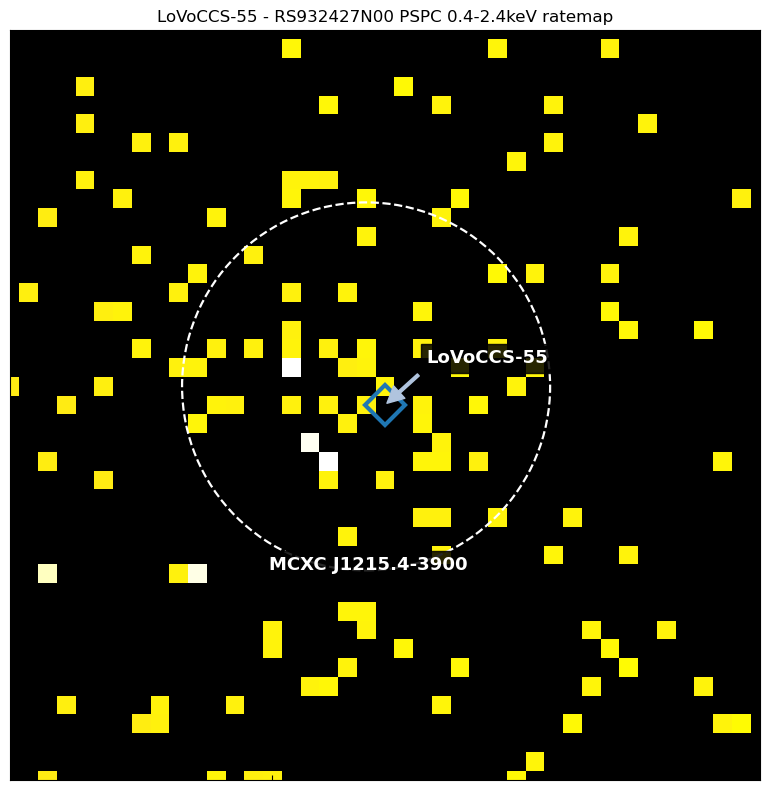

LoVoCCS-22


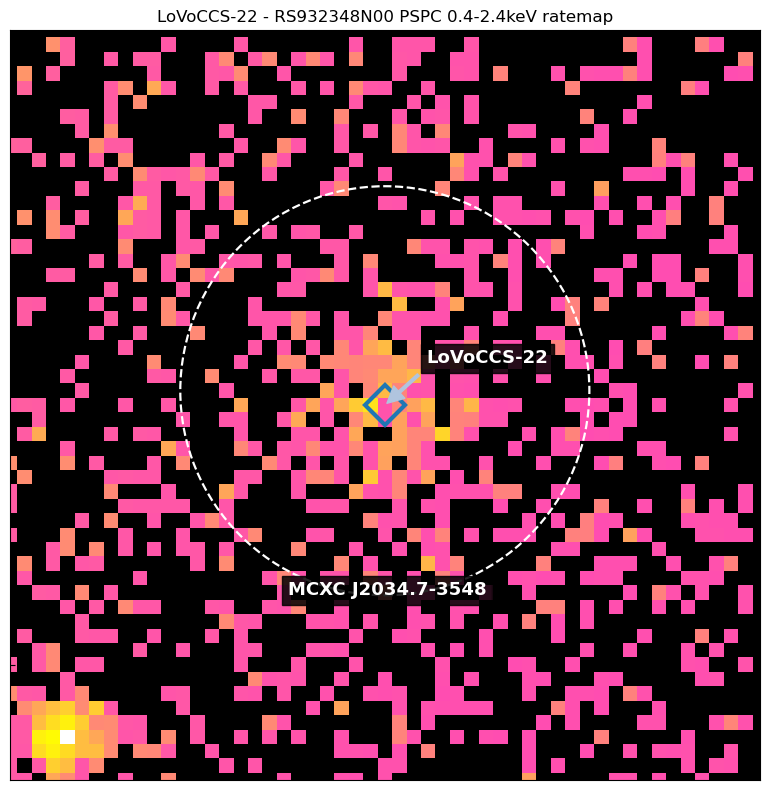

LoVoCCS-80


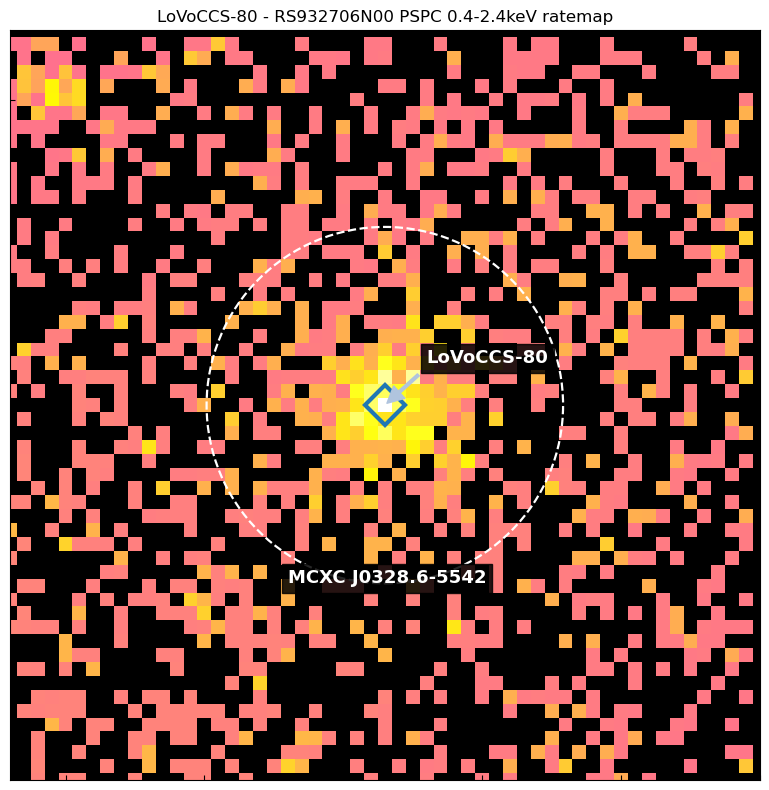

LoVoCCS-85


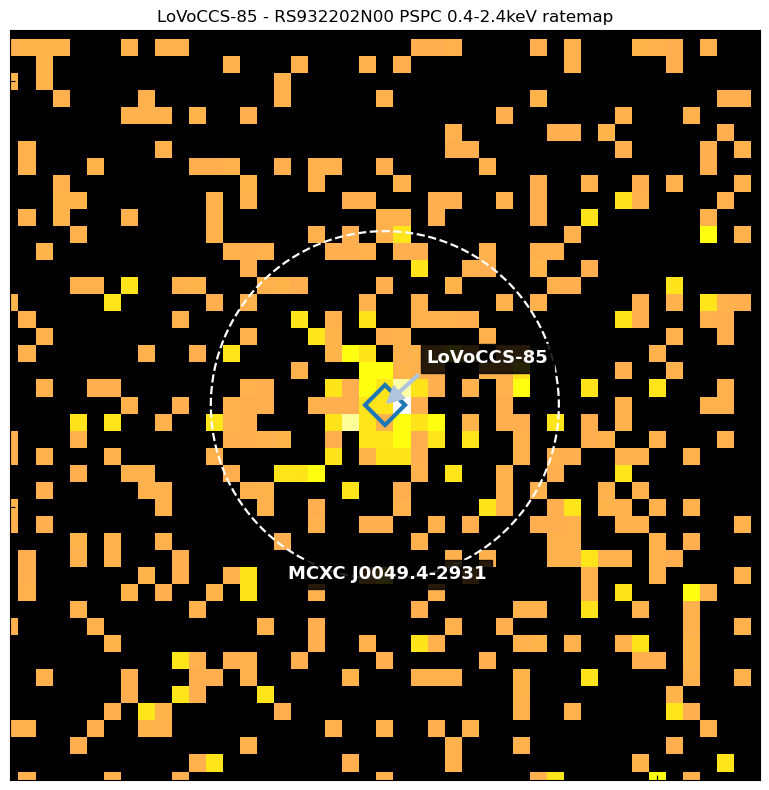

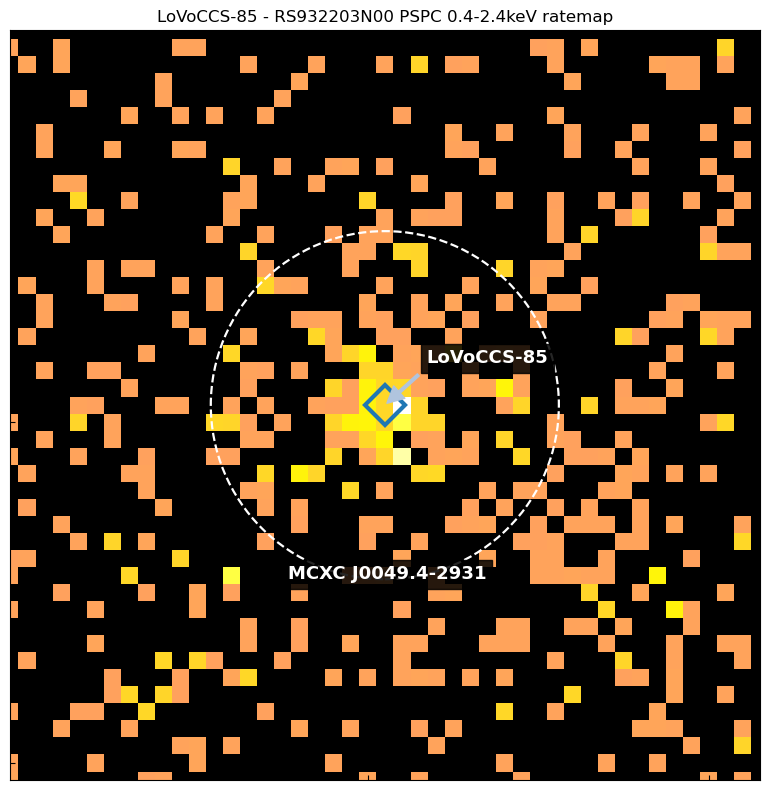

LoVoCCS-65


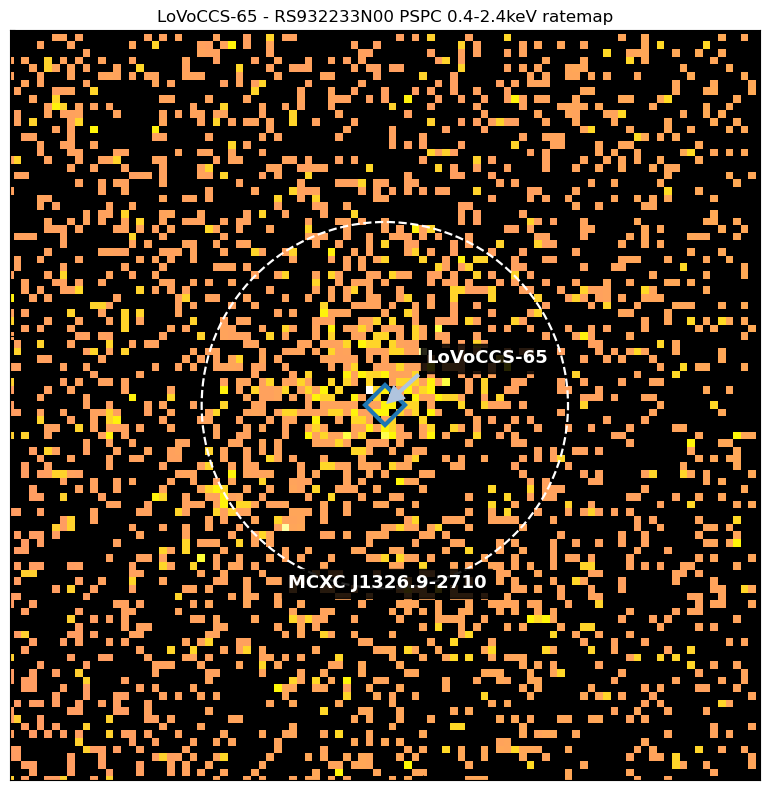

LoVoCCS-131


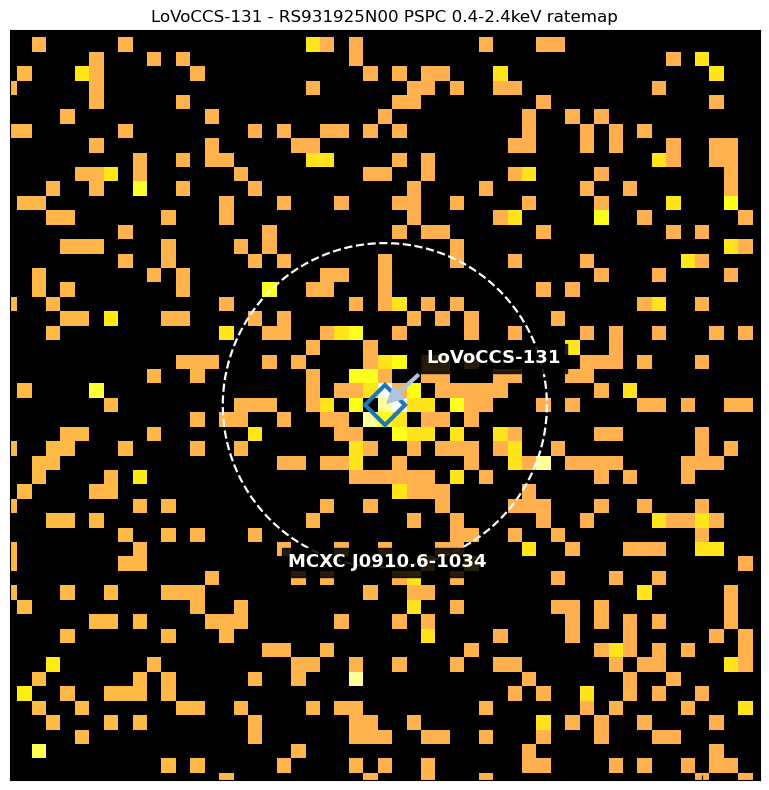

LoVoCCS-98


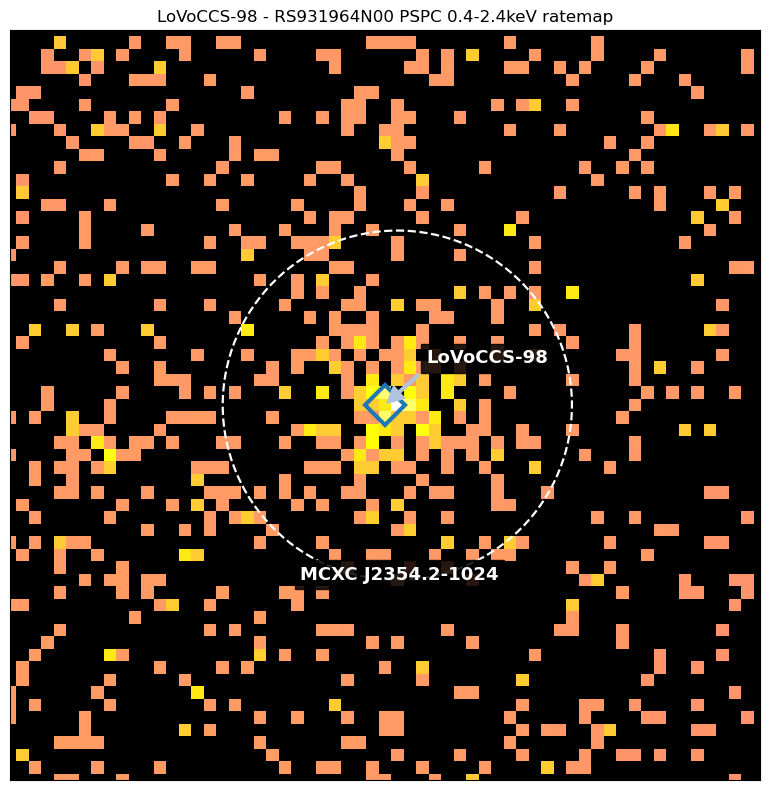

LoVoCCS-11


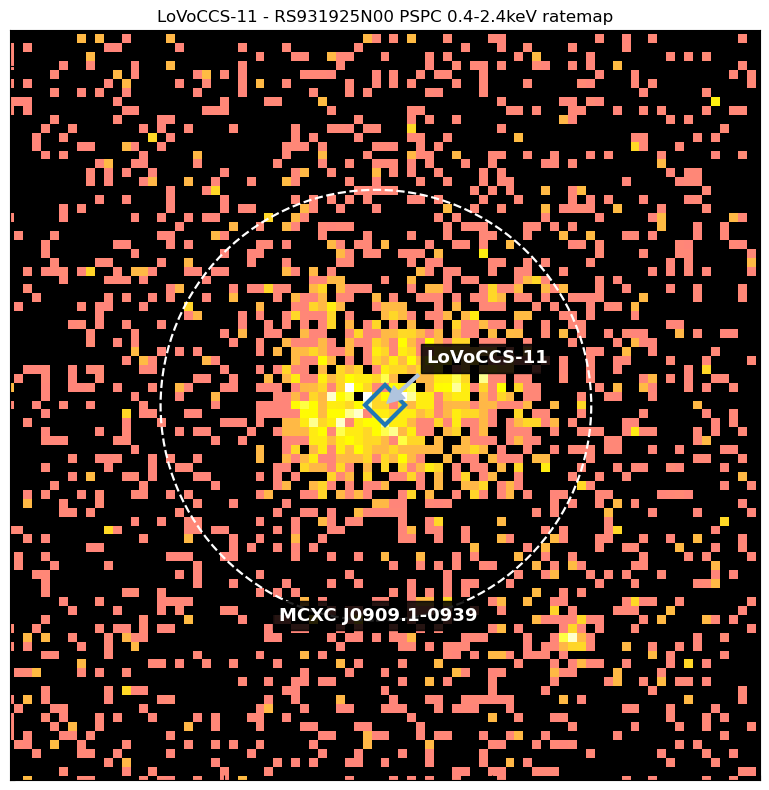

LoVoCCS-61


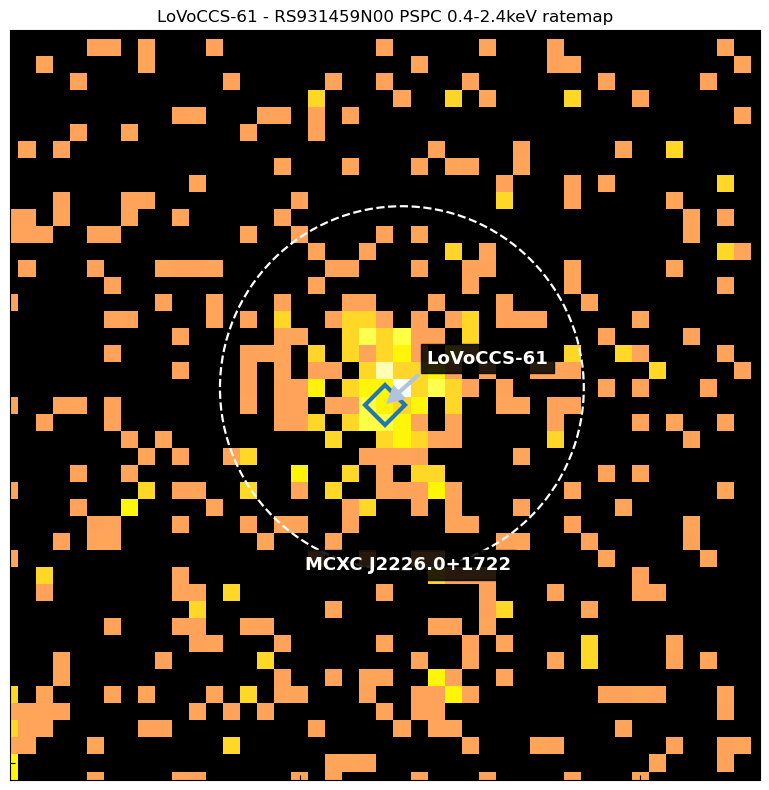

LoVoCCS-121


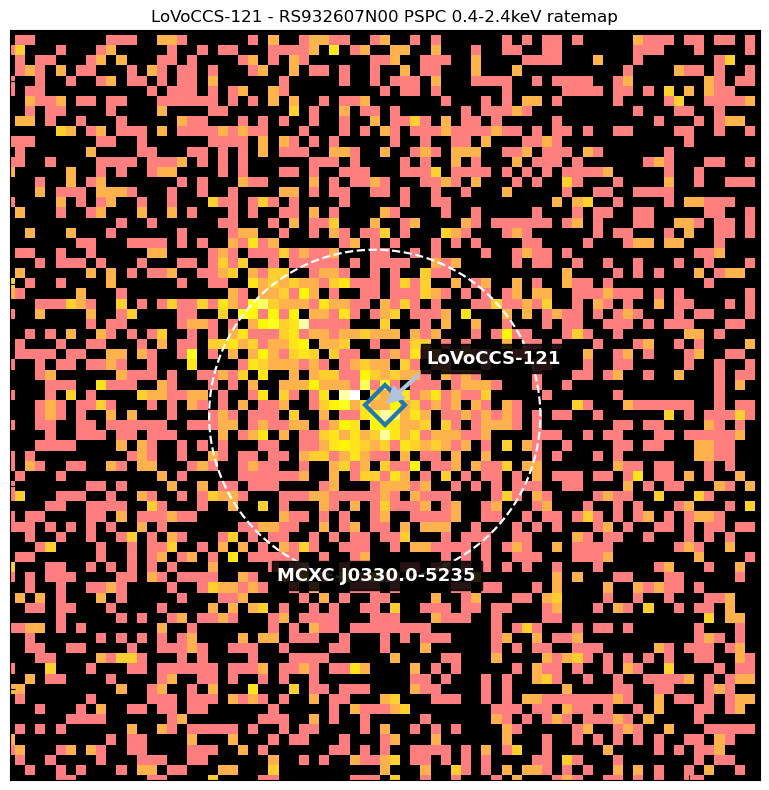

LoVoCCS-75


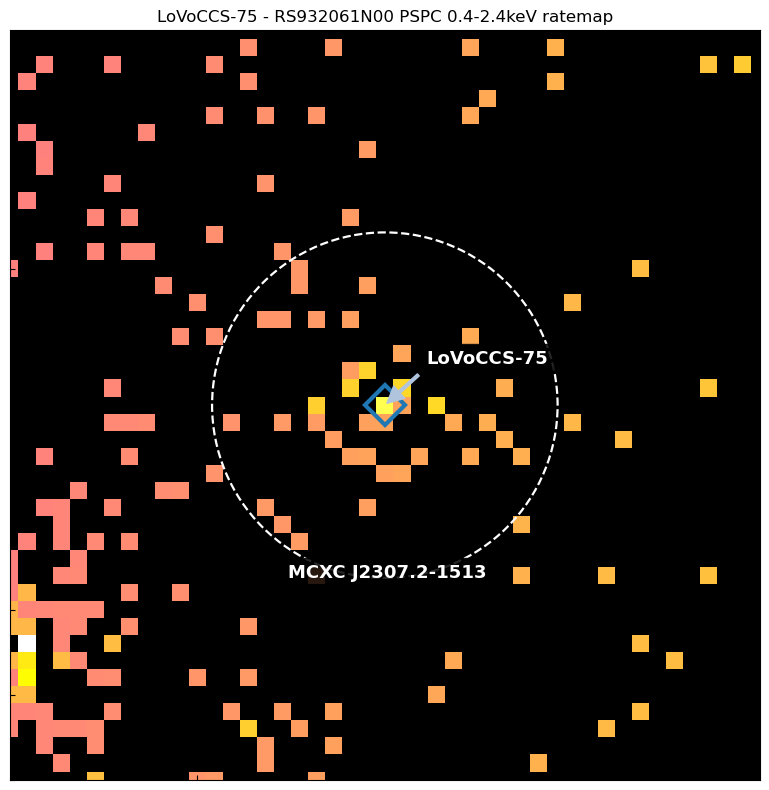

LoVoCCS-7


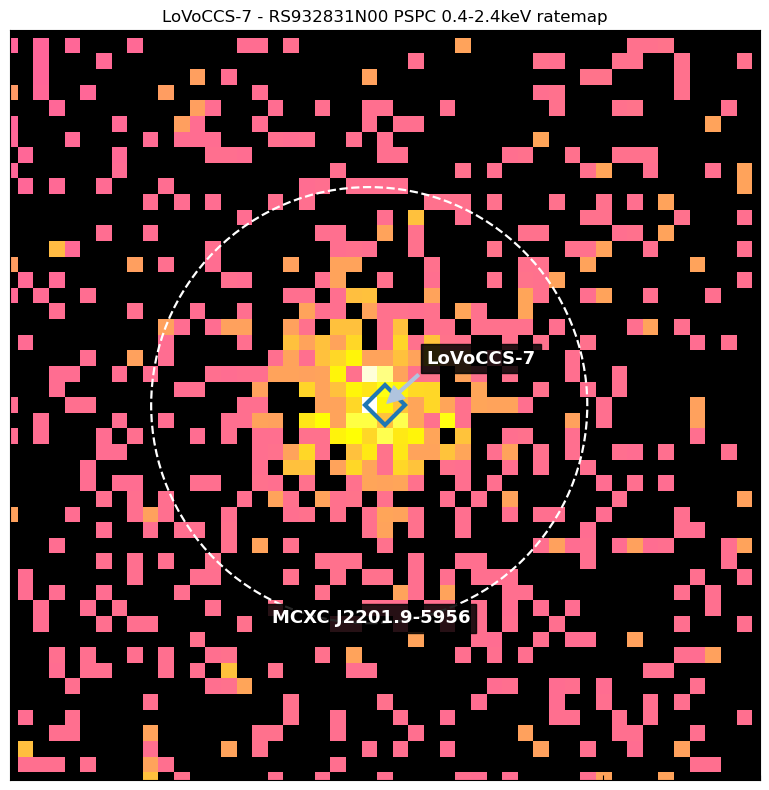

LoVoCCS-2


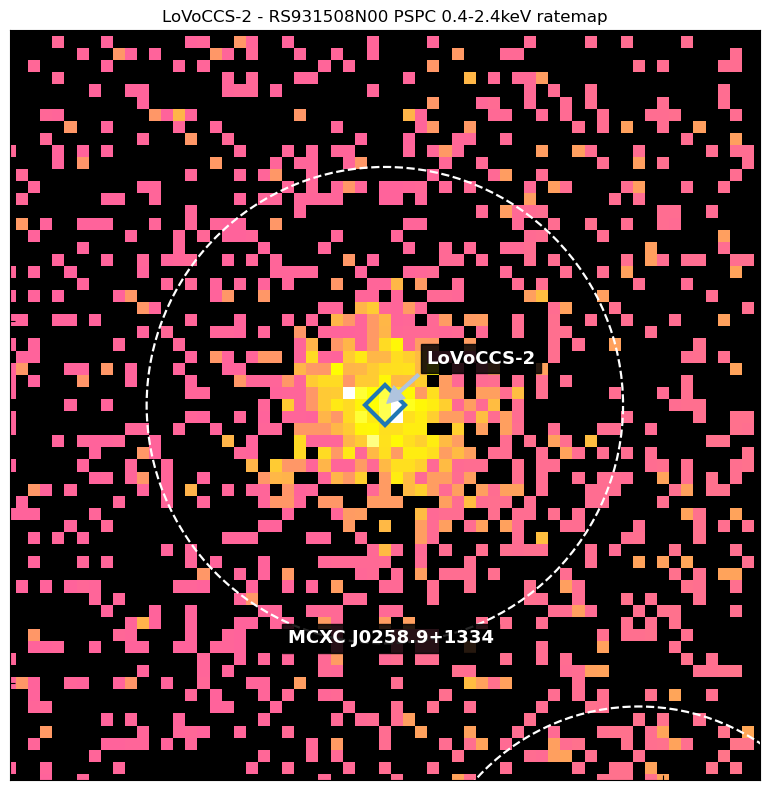

LoVoCCS-5


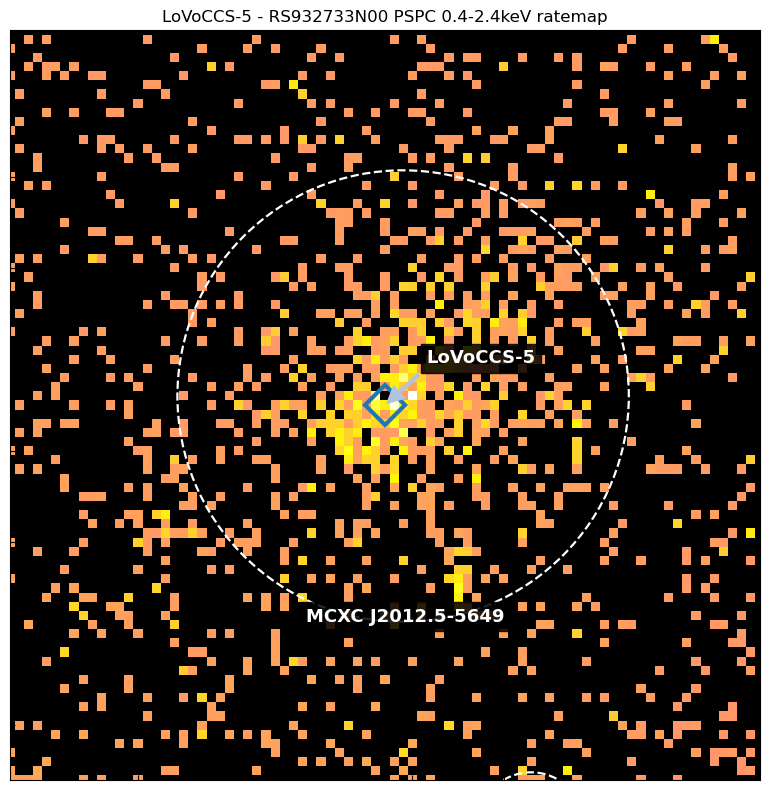

LoVoCCS-90


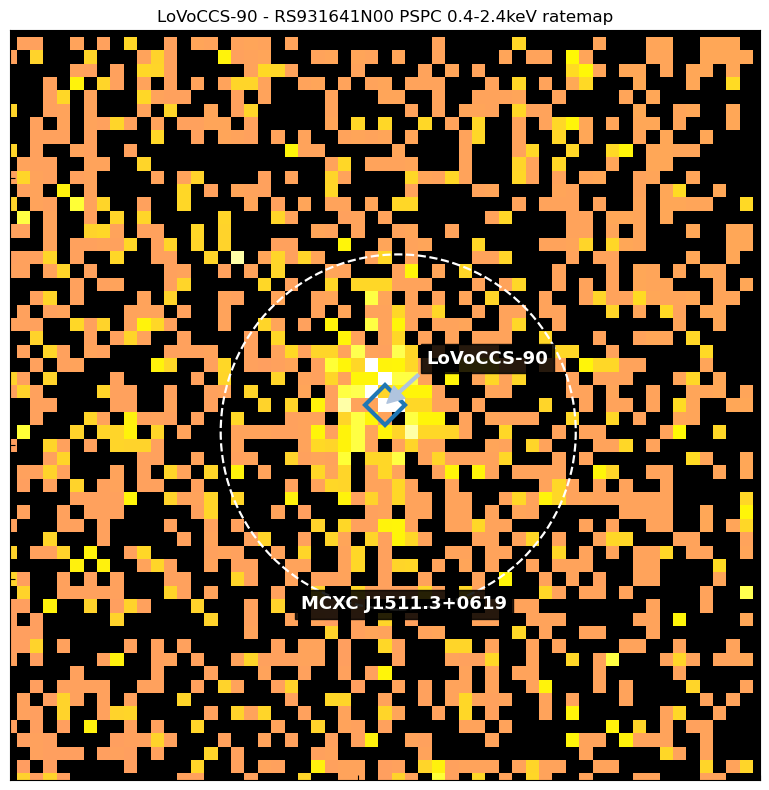

LoVoCCS-119


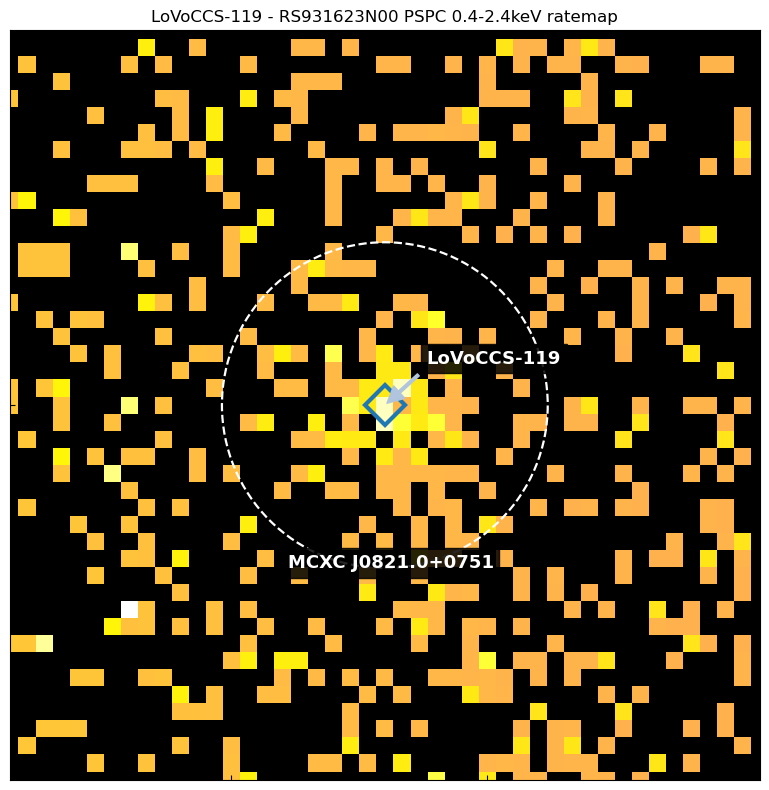

LoVoCCS-29


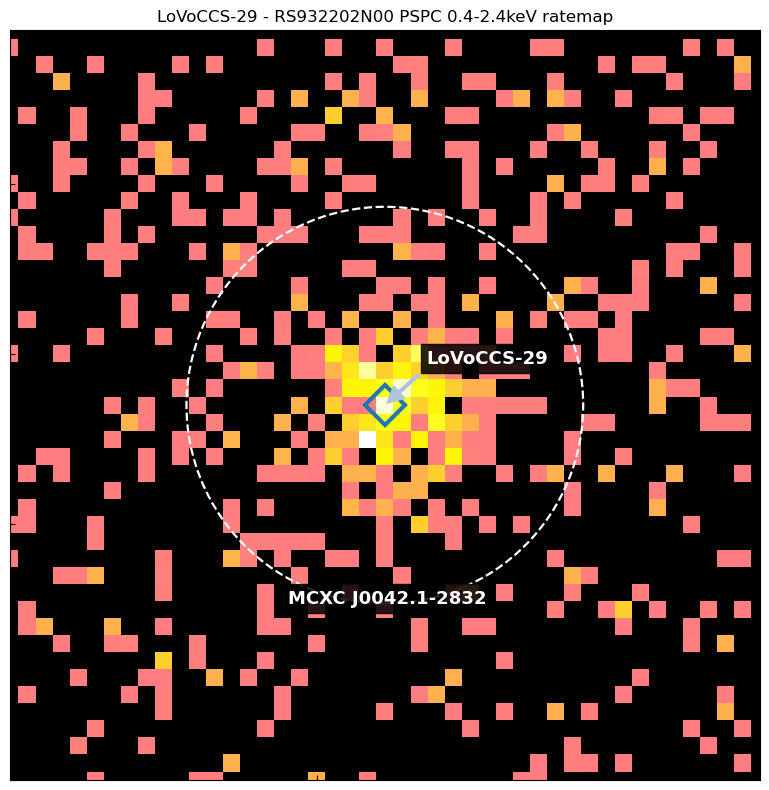

LoVoCCS-9


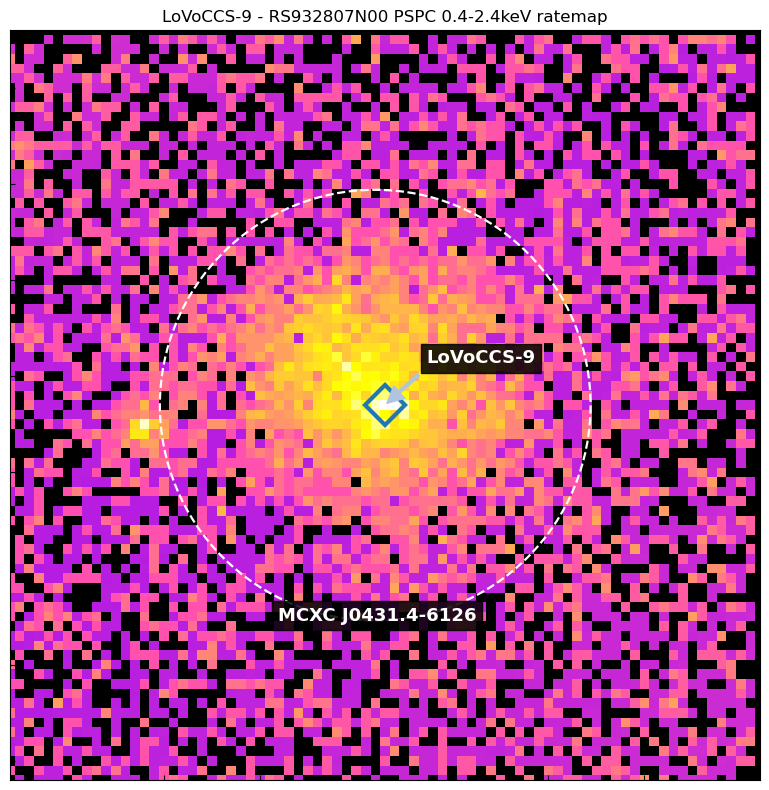

LoVoCCS-27


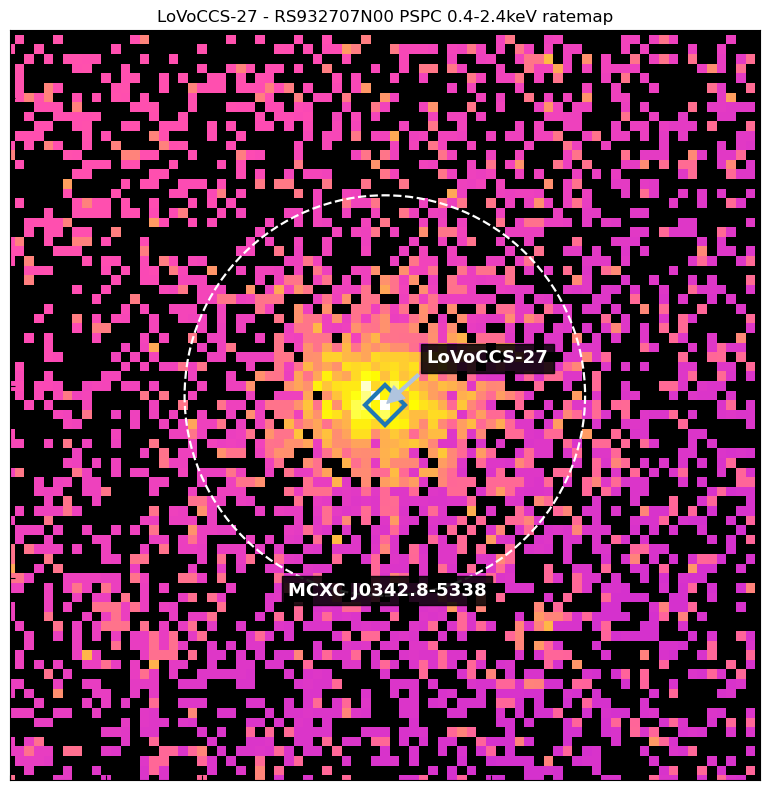

LoVoCCS-63


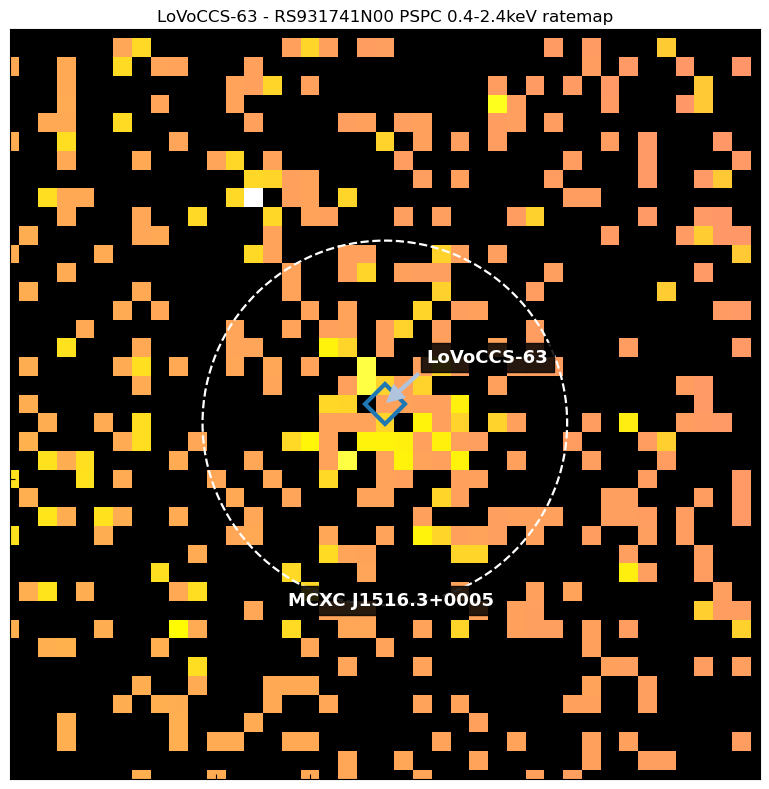

LoVoCCS-89


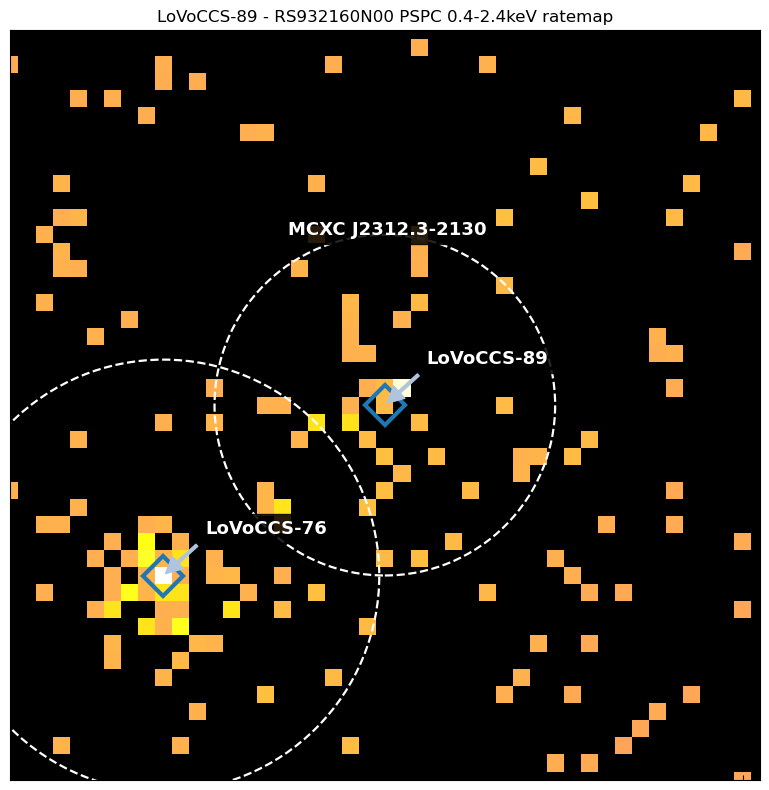

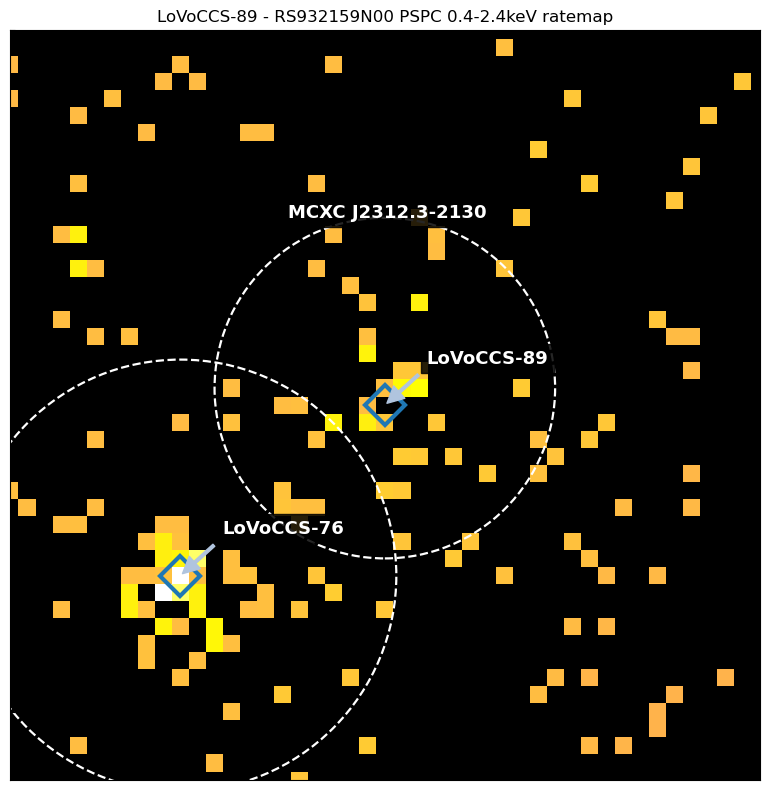

LoVoCCS-12


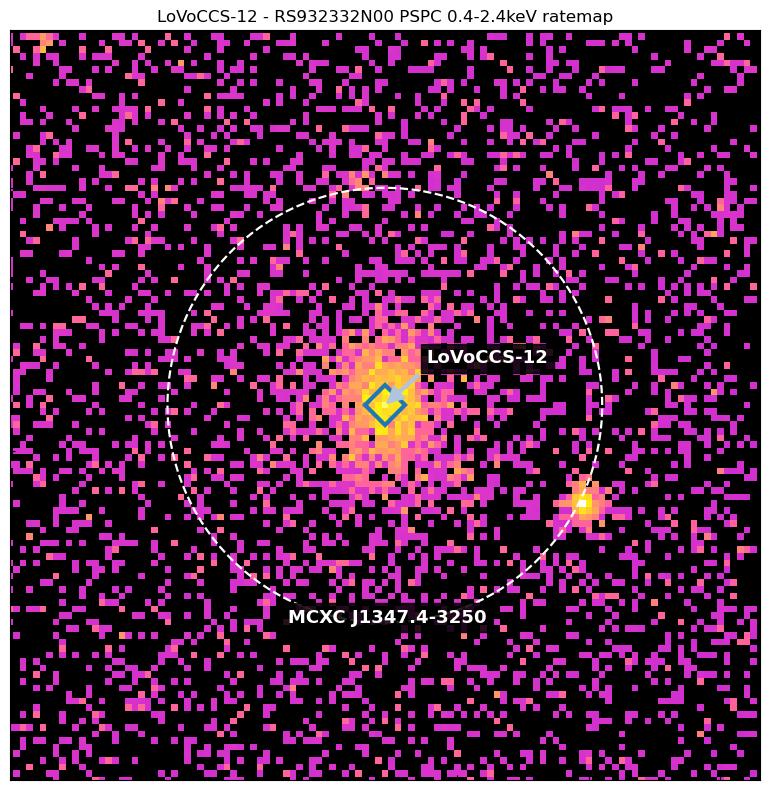

LoVoCCS-39


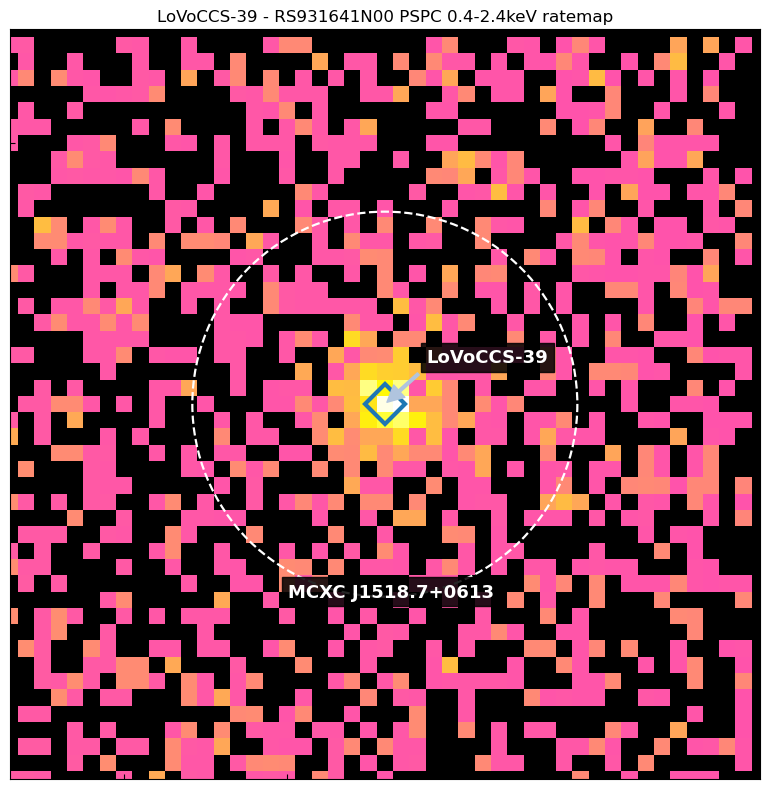

LoVoCCS-134


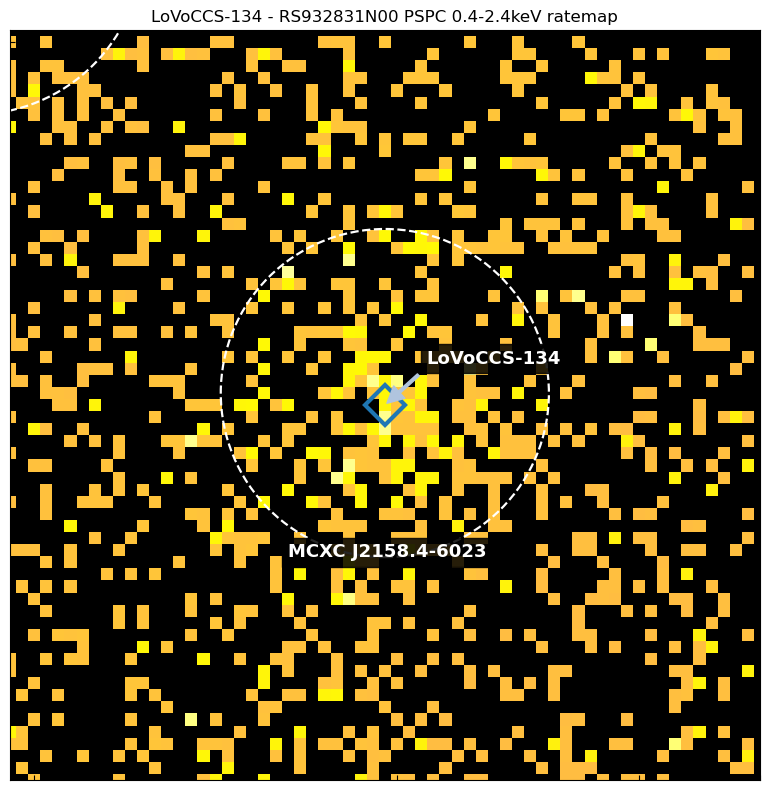

LoVoCCS-26


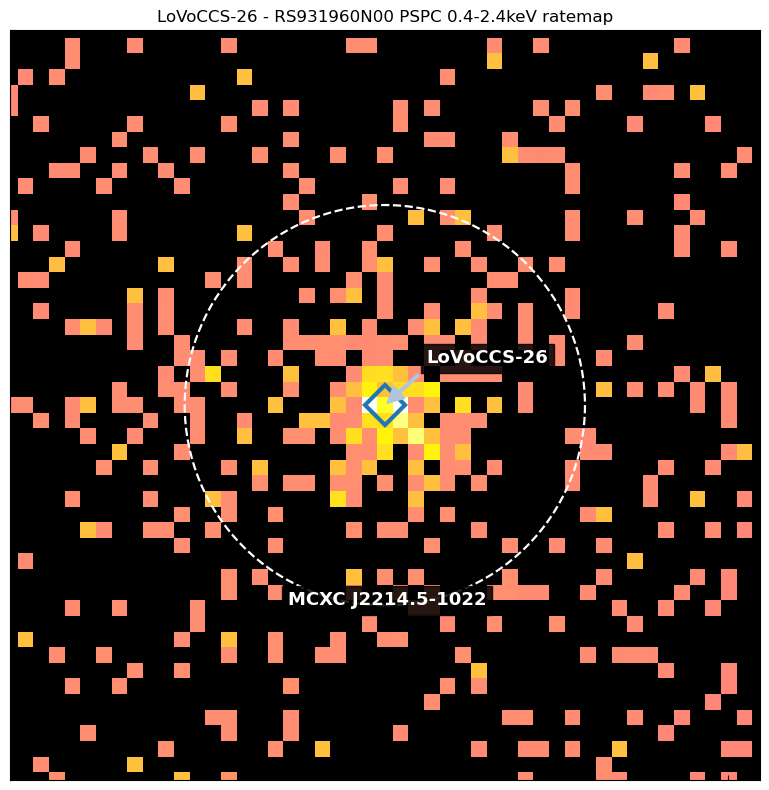

LoVoCCS-18


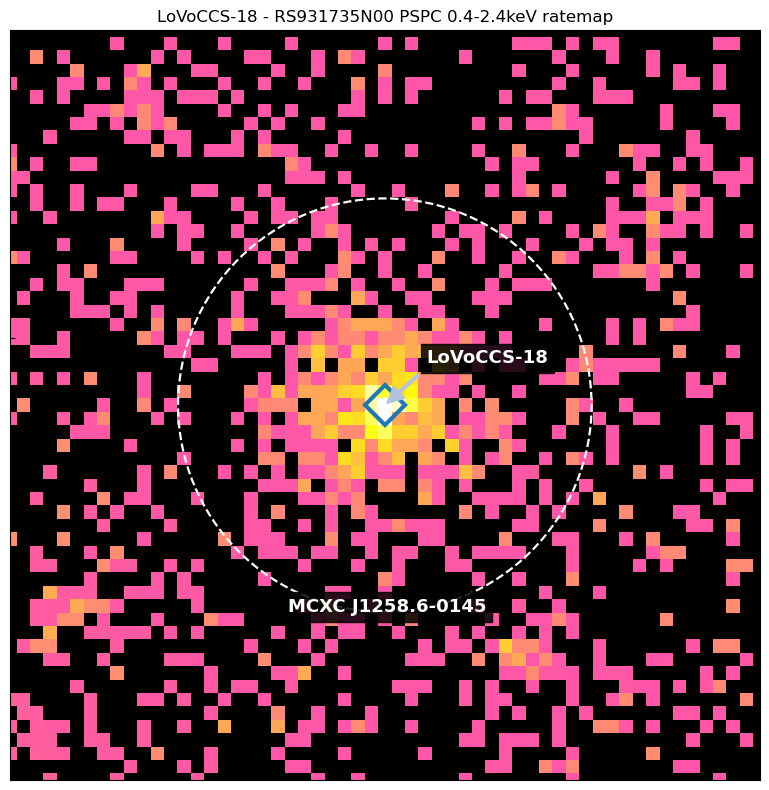

LoVoCCS-30


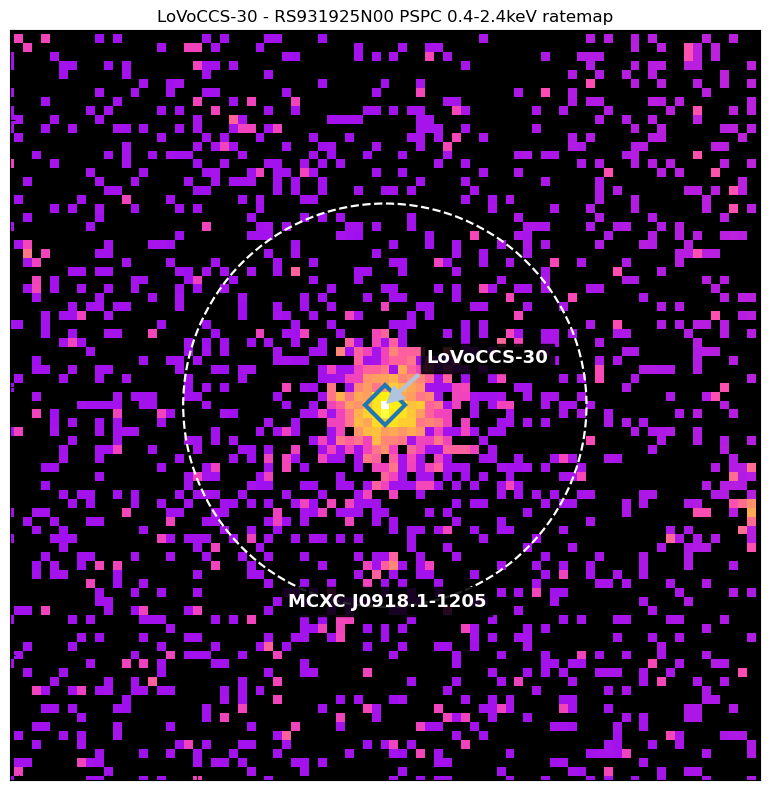

LoVoCCS-74


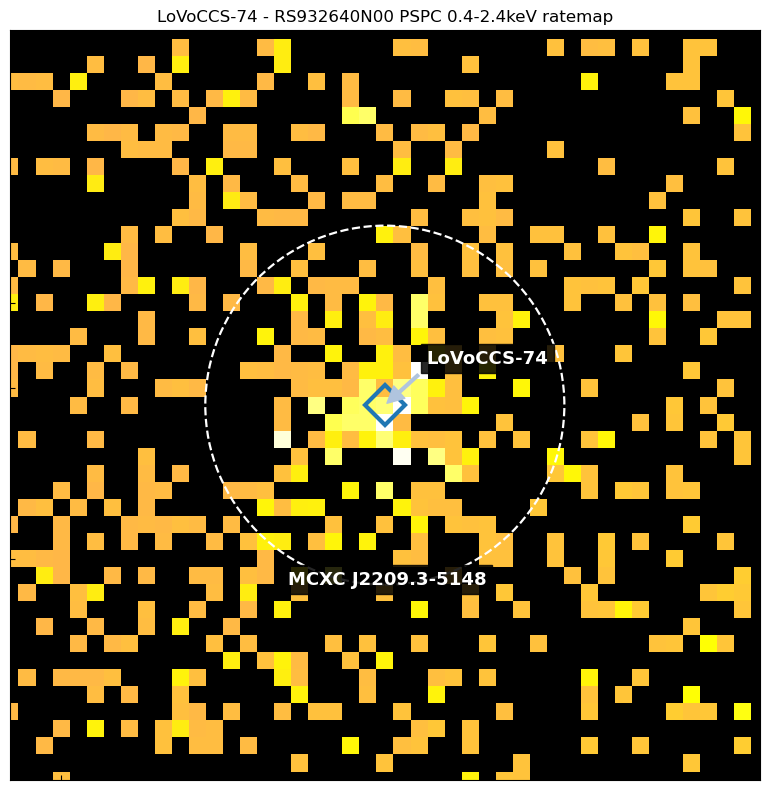

LoVoCCS-76


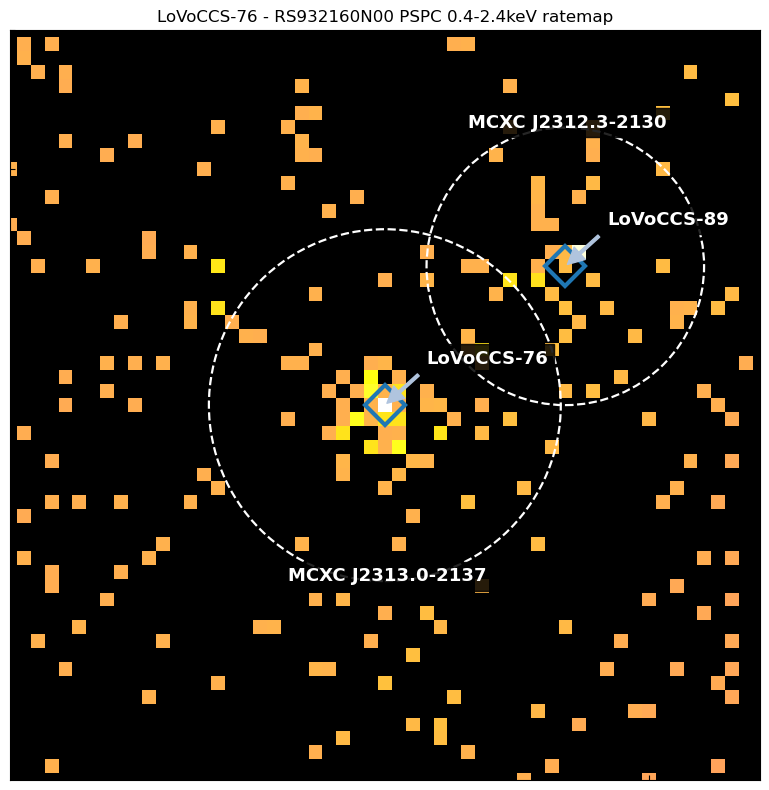

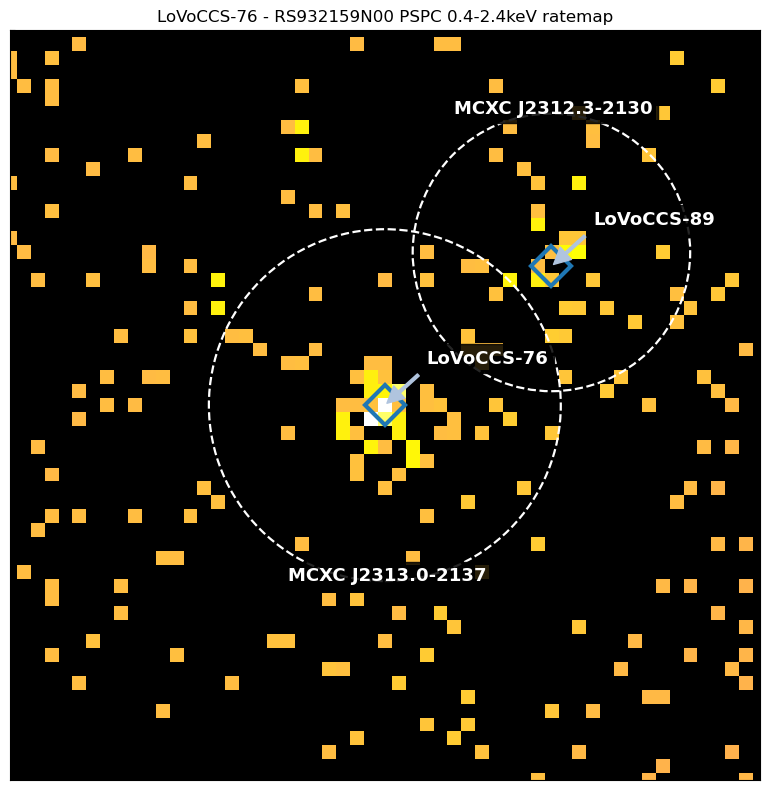

LoVoCCS-42


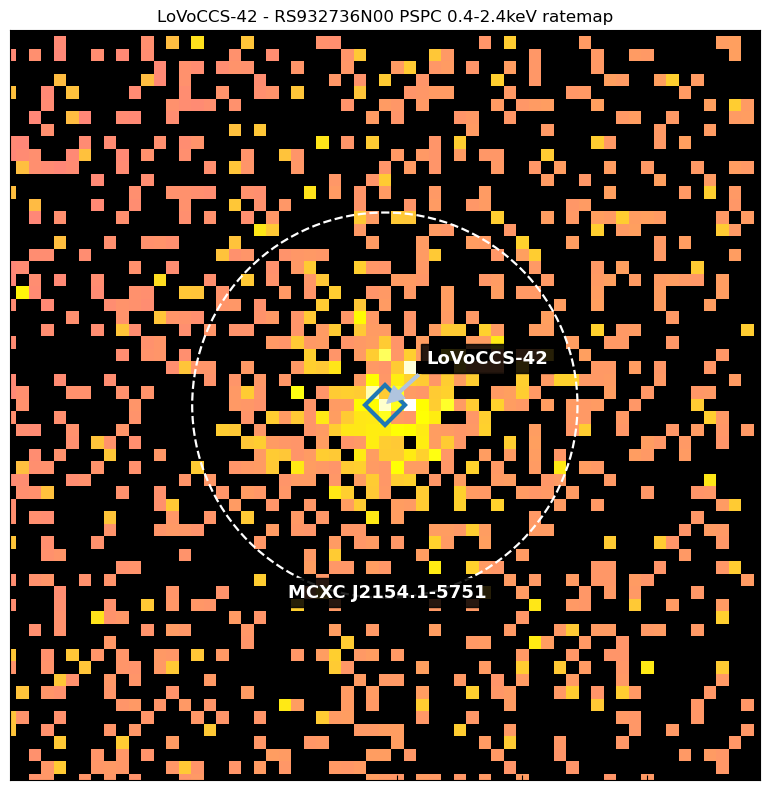

LoVoCCS-94


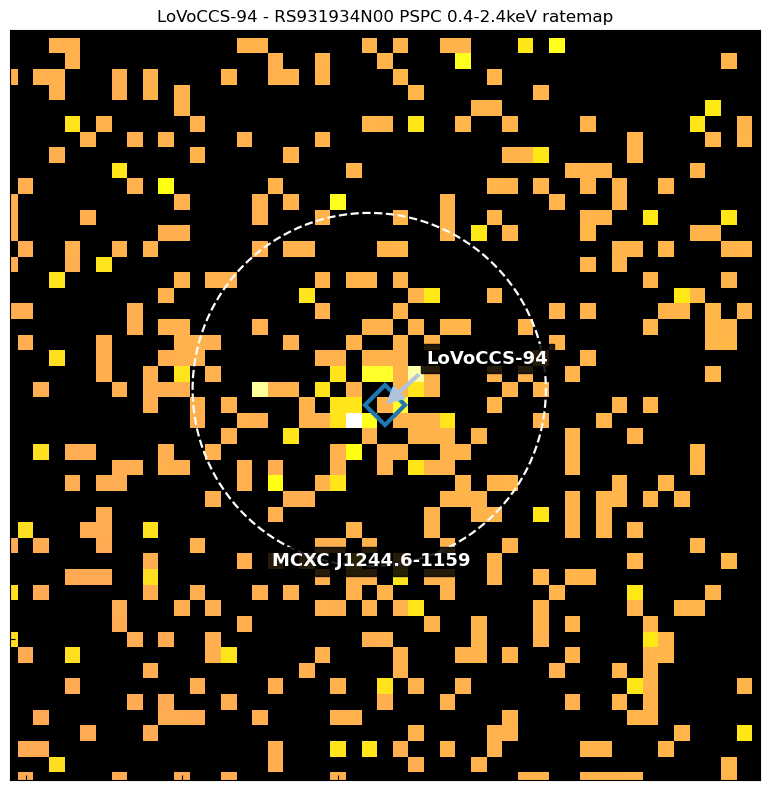

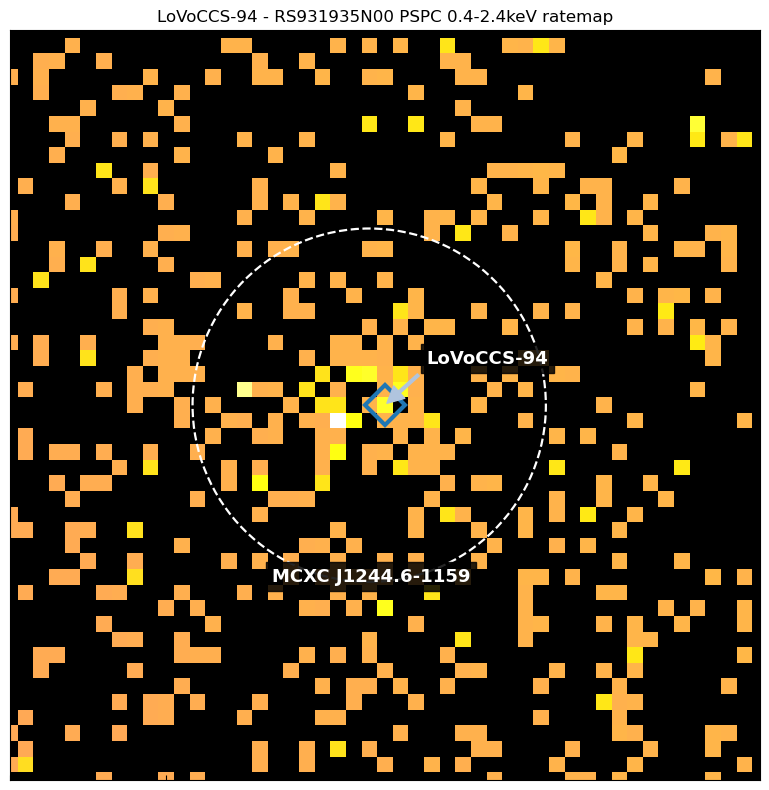

LoVoCCS-99


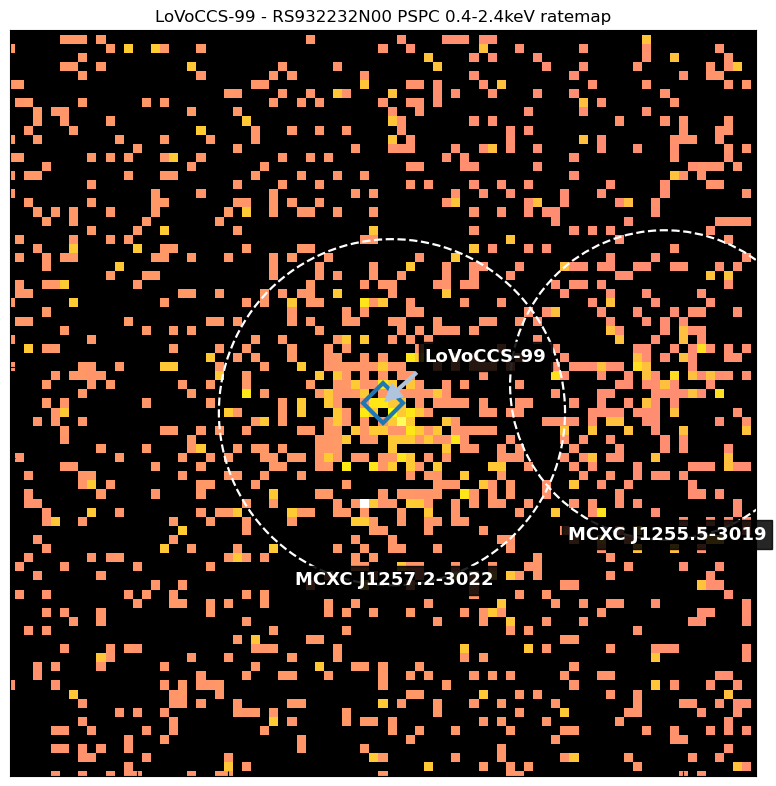

LoVoCCS-108


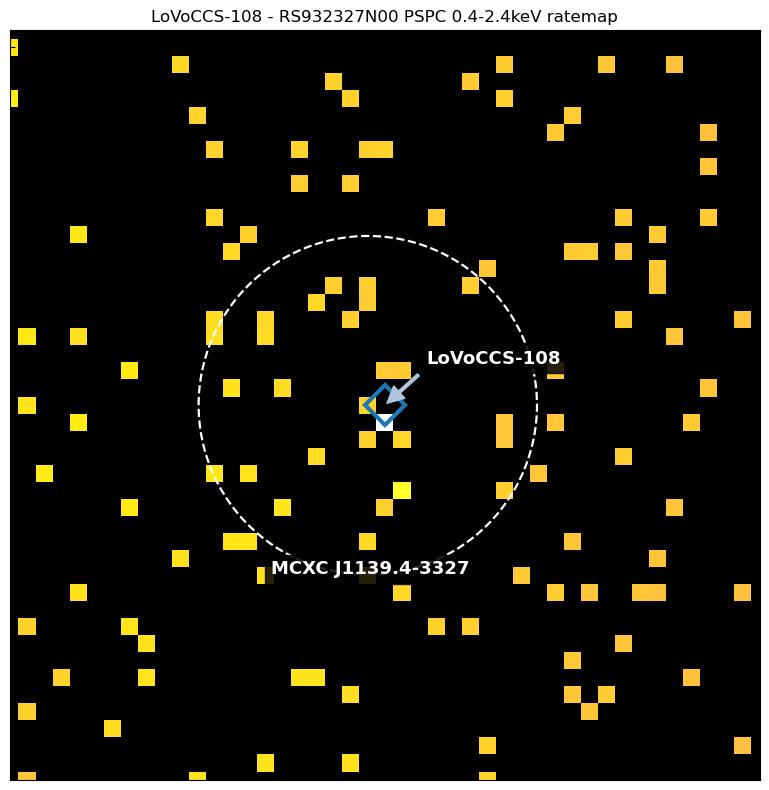

LoVoCCS-33


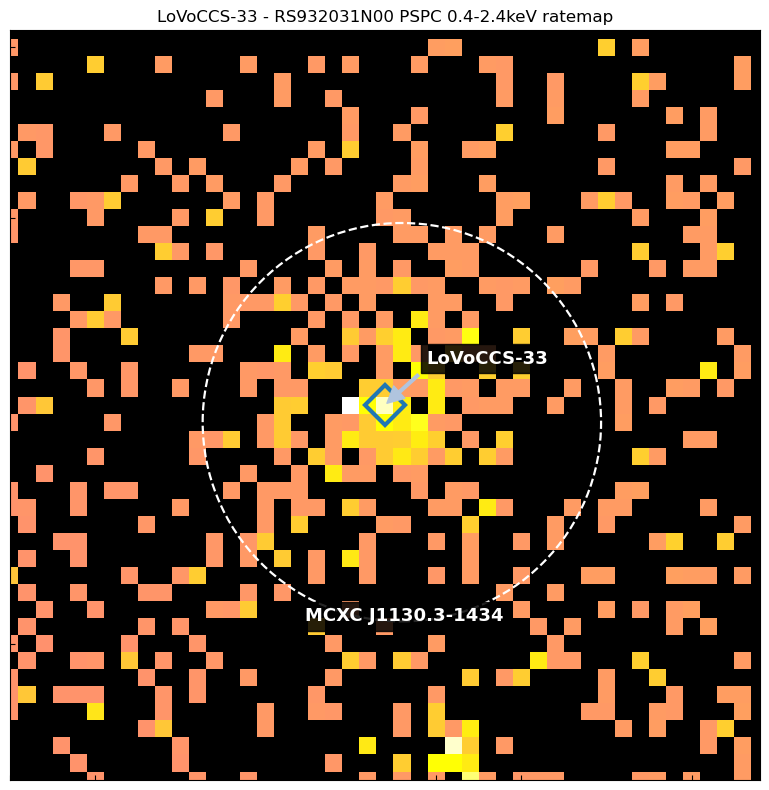

LoVoCCS-10


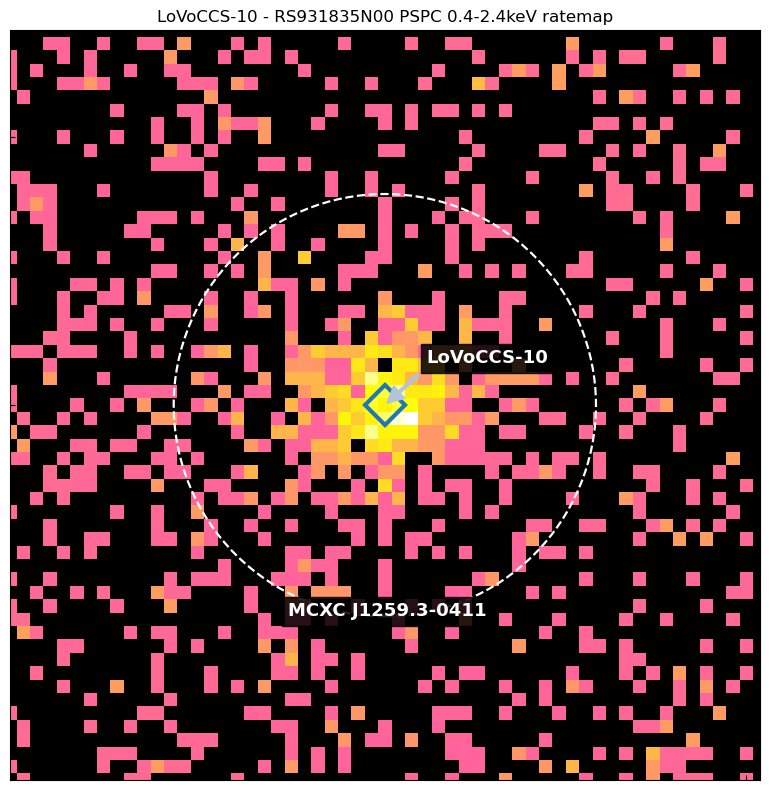

LoVoCCS-45


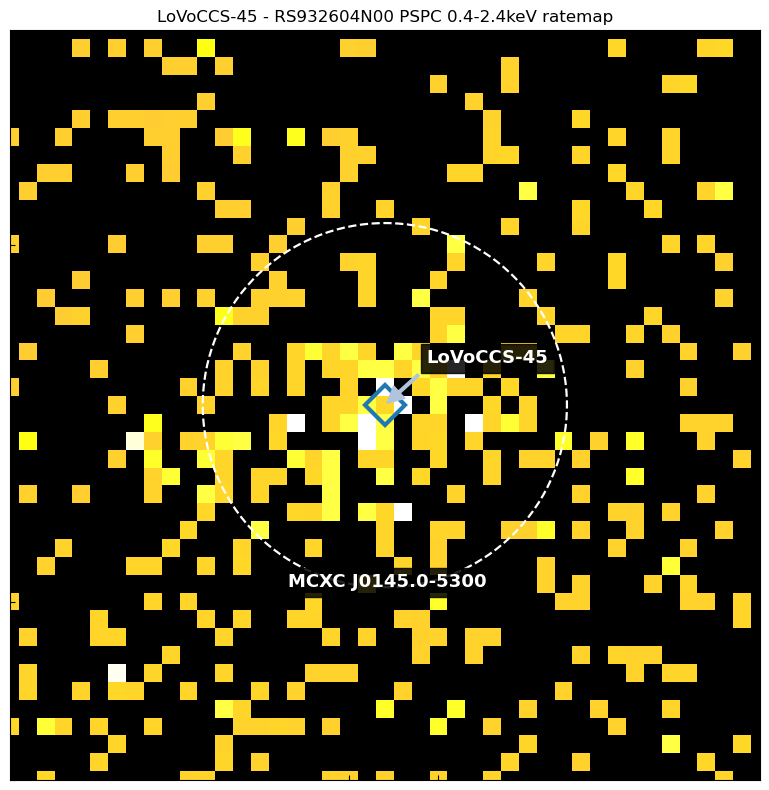

LoVoCCS-49


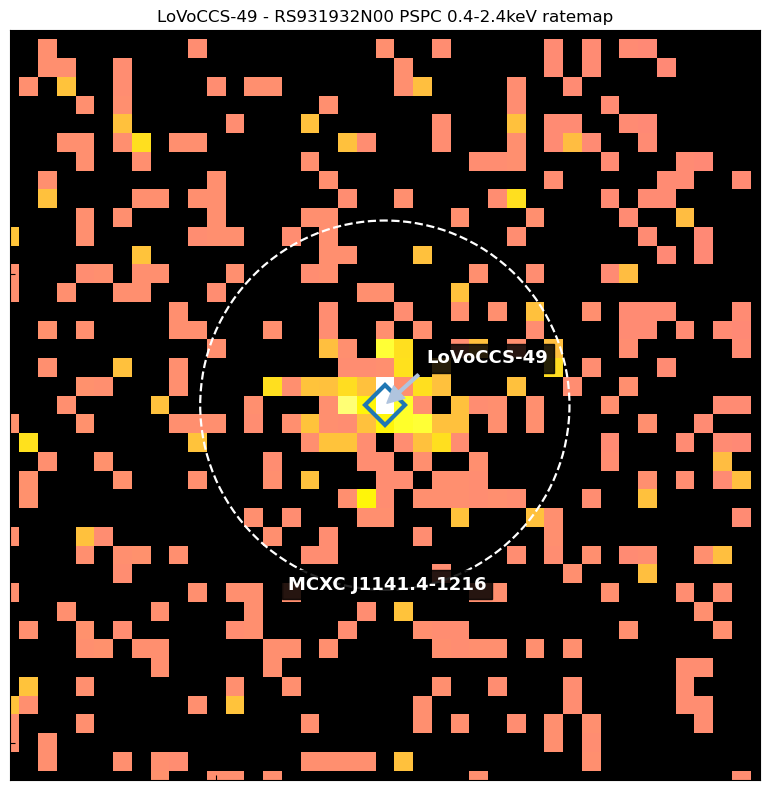

LoVoCCS-31


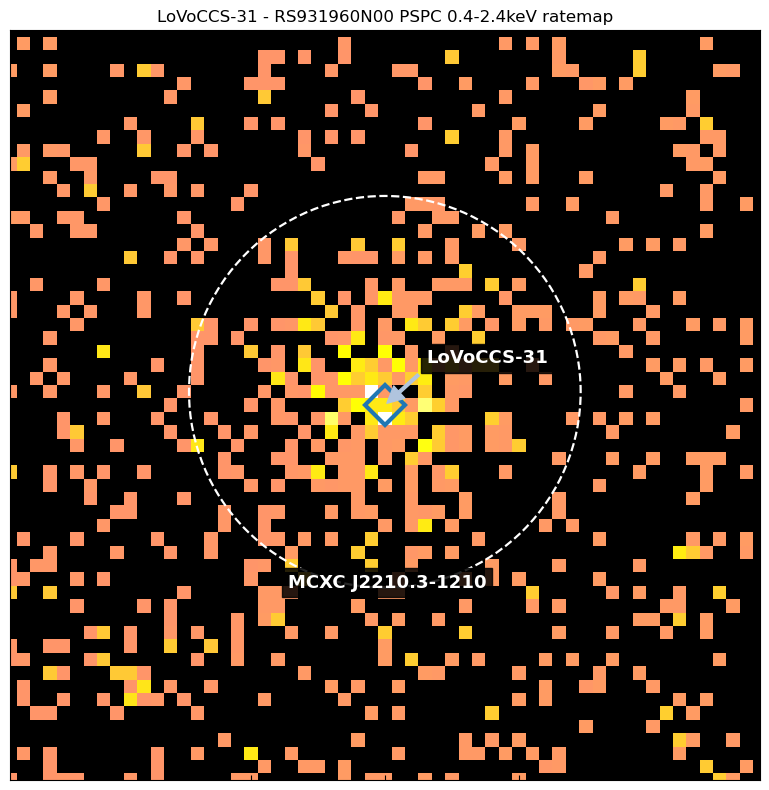

In [10]:
visualise_rass(split_clusters=False, label_on_top=['MCXC J1254.3-2901', 'MCXC J2312.3-2130'])